# 目的
株価が過去1年の平均から、変化している場合に
その後の値段が戻ろうとするか調査する

# 方法
2019/6/15の終値が、過去1年の終値の平均から標準偏差いくつ分下げているかで銘柄をカテゴライズ

カテゴリー毎にその後半年での値動きを確認
  
※ 値動きは、30日間の移動平均を日ごとにプロットし、  
その近似直線の傾きにて、値上がり・値下がりを判断する

In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
import sys
sys.path.append('../src')

### データの読込

In [3]:
from data_control import data as dt
from analyze import graph as gh
from database.models import DailyChart

In [4]:
bgn_datetime = datetime(2018, 6, 16)
base_datetime = datetime(2019, 6, 15)
end_datetime = datetime(2019, 12, 15)

In [5]:
all_data = DailyChart.date_between(bgn_datetime, end_datetime)

2021-11-09 03:37:50,481 INFO sqlalchemy.engine.Engine SHOW VARIABLES LIKE 'sql_mode'
2021-11-09 03:37:50,482 INFO sqlalchemy.engine.Engine [raw sql] {}
2021-11-09 03:37:50,488 INFO sqlalchemy.engine.Engine SHOW VARIABLES LIKE 'lower_case_table_names'
2021-11-09 03:37:50,489 INFO sqlalchemy.engine.Engine [generated in 0.00125s] {}
2021-11-09 03:37:50,492 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2021-11-09 03:37:50,493 INFO sqlalchemy.engine.Engine [raw sql] {}
2021-11-09 03:37:50,496 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-11-09 03:37:50,507 INFO sqlalchemy.engine.Engine SELECT daily_chart.chart_date AS daily_chart_chart_date, daily_chart.description_code AS daily_chart_description_code, daily_chart.open AS daily_chart_open, daily_chart.high AS daily_chart_high, daily_chart.low AS daily_chart_low, daily_chart.close AS daily_chart_close, daily_chart.turnover AS daily_chart_turnover, daily_chart.vwap AS daily_chart_vwap, daily_chart.execution_count AS daily_chart_execut

In [6]:
data = dt.separate_by_code(all_data)
data = dt.filter_missing_stocks(data, bgn_datetime, end_datetime)

In [7]:
# 銘柄数
len(data.keys())

2984

### 平均から現在値がどれくらい乖離しているかでカテゴライズ

In [8]:
df = pd.DataFrame()
for code, d in data.items():
    d = d[(d['chart_date'] >= datetime(2018, 6, 16)) & (d['chart_date'] <= datetime(2019, 6, 15))]
    describe = pd.DataFrame([d['close'].describe()[['mean', 'std']]])
    describe['code'] = code
    describe['now'] = float(d.sort_values('chart_date').tail(1)['close'])
    df = pd.concat([df, describe])
df = df.reset_index().drop('index', axis=1)

In [9]:
df['gap'] = df['now'] - df['mean']
df['gap_rate'] = df['gap'] / df['std']

In [10]:
df.head()

mean          std  code      now          gap  gap_rate
0   3070.680498   266.966527  1301   2693.0  -377.680498 -1.414711
1   1717.759336    81.868035  1305   1639.0   -78.759336 -0.962028
2   1694.937759    80.685760  1306   1617.0   -77.937759 -0.965942
3   1677.311203    79.493020  1308   1600.0   -77.311203 -0.972553
4  29742.157676  2032.929616  1309  31850.0  2107.842324  1.036850

In [11]:
down_over_2std_codes = df[df['gap_rate'] <= -2.0].code
down_between_1_5_and_2_0std_codes = df[(-2.0 < df['gap_rate']) & (df['gap_rate'] <= -1.5)].code
down_between_1_0_and_1_5std_codes = df[(-1.5 < df['gap_rate']) & (df['gap_rate'] <= -1.0)].code
down_between_0_5_and_1_0std_codes = df[(-1.0 < df['gap_rate']) & (df['gap_rate'] <= -0.5)].code
down_between_0_0_and_0_5std_codes = df[(-0.5 < df['gap_rate']) & (df['gap_rate'] <= -0)].code
up_between_0_0_and_0_5std_codes = df[(0.0 < df['gap_rate']) & (df['gap_rate'] <= 0.5)].code
up_between_0_5_and_1_0std_codes = df[(0.5 < df['gap_rate']) & (df['gap_rate'] <= 1.0)].code
up_between_1_0_and_1_5std_codes = df[(1.0 < df['gap_rate']) & (df['gap_rate'] <= 1.5)].code
up_between_1_5_and_2_0std_codes = df[(1.5 < df['gap_rate']) & (df['gap_rate'] <= 2.0)].code
up_over_2std_codes = df[(2.0 < df['gap_rate'])].code

In [12]:
print('2σ以上下がっている銘柄数: {}'.format(len(down_over_2std_codes)))
print('1.5σ ~ 2.0σ下がっている銘柄数: {}'.format(len(down_between_1_5_and_2_0std_codes)))
print('1.0σ ~ 1.5σ下がっている銘柄数: {}'.format(len(down_between_1_0_and_1_5std_codes)))
print('0.5σ ~ 1.0σ下がっている銘柄数: {}'.format(len(down_between_0_5_and_1_0std_codes)))
print('0.0σ ~ 0.5σ下がっている銘柄数: {}'.format(len(down_between_0_0_and_0_5std_codes)))
print('0.0σ ~ 0.5σ上がって柄数数: {}'.format(len(up_between_0_0_and_0_5std_codes)))
print('0.5σ ~ 1.0σ上がって柄数数: {}'.format(len(up_between_0_5_and_1_0std_codes)))
print('1.0σ ~ 1.5σ上がって柄数数: {}'.format(len(up_between_1_0_and_1_5std_codes)))
print('1.5σ ~ 2.0σ上がって柄数数: {}'.format(len(up_between_1_5_and_2_0std_codes)))
print('2σ以上上がっている銘柄数: {}'.format(len(up_over_2std_codes)))

2σ以上下がっている銘柄数: 143
1.5σ ~ 2.0σ下がっている銘柄数: 382
1.0σ ~ 1.5σ下がっている銘柄数: 738
0.5σ ~ 1.0σ下がっている銘柄数: 621
0.0σ ~ 0.5σ下がっている銘柄数: 324
0.0σ ~ 0.5σ上がって柄数数: 246
0.5σ ~ 1.0σ上がって柄数数: 183
1.0σ ~ 1.5σ上がって柄数数: 121
1.5σ ~ 2.0σ上がって柄数数: 100
2σ以上上がっている銘柄数: 126


In [13]:
# 割合
print(len(down_over_2std_codes) / len(data.keys()))
print(len(down_between_1_5_and_2_0std_codes) / len(data.keys()))
print(len(down_between_1_0_and_1_5std_codes) / len(data.keys()))
print(len(down_between_0_5_and_1_0std_codes) / len(data.keys()))
print(len(down_between_0_0_and_0_5std_codes) / len(data.keys()))
print(len(up_between_0_0_and_0_5std_codes) / len(data.keys()))
print(len(up_between_0_5_and_1_0std_codes) / len(data.keys()))
print(len(up_between_1_0_and_1_5std_codes) / len(data.keys()))
print(len(up_between_1_5_and_2_0std_codes) / len(data.keys()))
print(len(up_over_2std_codes) / len(data.keys()))

0.04792225201072386
0.12801608579088472
0.24731903485254692
0.20810991957104558
0.10857908847184987
0.0824396782841823
0.061327077747989275
0.04054959785522788
0.03351206434316354
0.04222520107238606


### 値動きを調べる

In [14]:
# 30日移動平均を取得
data = dt.calc_moving_average(data, days=30, column='close')

In [15]:
# MEMO: +/-の数 最高いくら利益が、どのくらいの期間で取れるか、　損に関しても同様

In [16]:
def check(code_list: list, show_graph=False):
    grad_list = list()
    max_list = list()
    max_days_list = list()
    min_list = list()
    min_days_list = list()

    for code in code_list:
        # データの絞り込み
        d = data[code]
        d = d[d['chart_date'] >= datetime(2019, 6, 15)]
        d = d.reset_index()
        # 回帰直線の追加
        x = np.linspace(1, len(d), len(d))
        a, b = np.polyfit(x, d['m_avg_30_close'], 1)
        regression_line = a * x + b
        d = d.assign(regression=regression_line)
        # 損益の取得
        buy = float(d.head(1)['close'])
        std = float(d.head(1)['m_std_30_close'])
        d['profit_or_loss'] = d['m_avg_30_close'] - buy
        max_idx = d['profit_or_loss'].idxmax()
        min_idx = d['profit_or_loss'].idxmin()
        max_by_std = float(d[d.index==max_idx]['profit_or_loss']) / std
        min_by_std = float(d[d.index==min_idx]['profit_or_loss']) / std
        # 集計
        grad_list.append(a)
        max_list.append(max_by_std)
        max_days_list.append(max_idx)
        min_list.append(min_by_std)
        min_days_list.append(min_idx)
        # グラフの描画
        if show_graph:
            print(code)
            gh.show_graph_together(d, ['m_avg_30_close', 'regression'], ['b', 'r'])
    
    check_df = pd.DataFrame()
    check_df = check_df.assign(grad=grad_list)
    check_df = check_df.assign(max_profit=max_list)
    check_df = check_df.assign(max_days=max_days_list)
    check_df = check_df.assign(min_profit=min_list)
    check_df = check_df.assign(min_days=min_days_list)
    return check_df

### 全銘柄

In [17]:
check_df = check(data.keys())

In [18]:
plus = len(check_df[check_df['grad'] > 0])
minus = len(check_df[check_df['grad'] < 0])

In [19]:
check_df.describe()

grad   max_profit     max_days   min_profit     min_days
count  2984.000000  2984.000000  2984.000000  2984.000000  2984.000000
mean      7.331298     4.687612    83.983244    -1.962989    47.860925
std      56.265449     6.904889    47.434904     2.205276    35.641176
min     -35.249139    -2.682414     0.000000   -19.543498     0.000000
25%      -0.246545     1.067466    33.000000    -2.820242     8.000000
50%       0.483714     2.926267   115.000000    -1.443152    59.000000
75%       2.010867     6.389981   122.000000    -0.479429    65.000000
max    1038.568551   206.042407   122.000000     1.871544   122.000000

In [20]:
print('plus: {}'.format(plus / len(data)))
print('minus: {}'.format(minus / len(data)))

plus: 0.6715817694369973
minus: 0.3284182305630027


### 2.0σ 以上下がった銘柄

1333


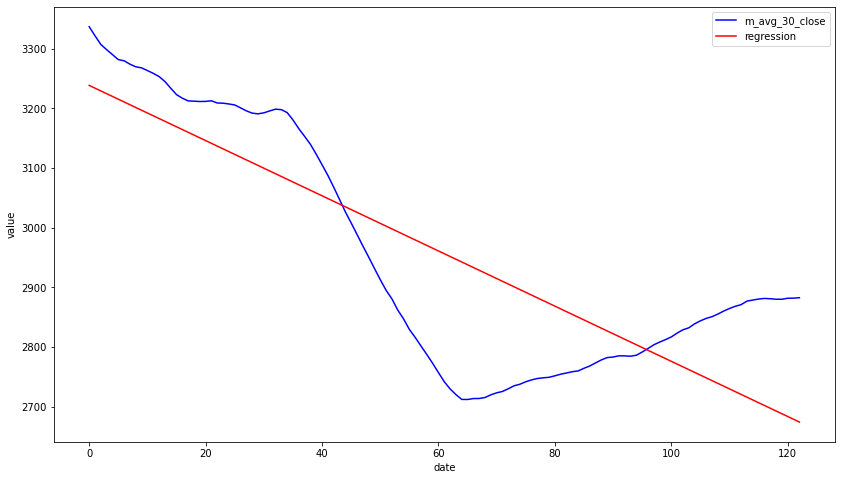

1379


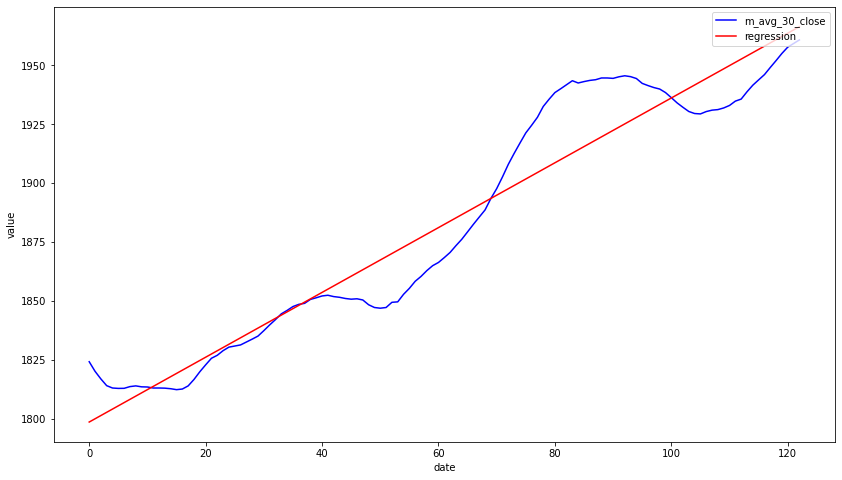

1720


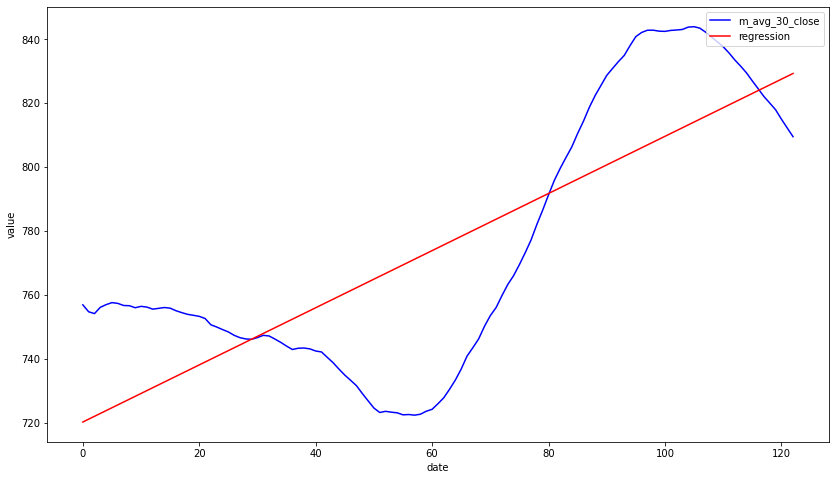

1808


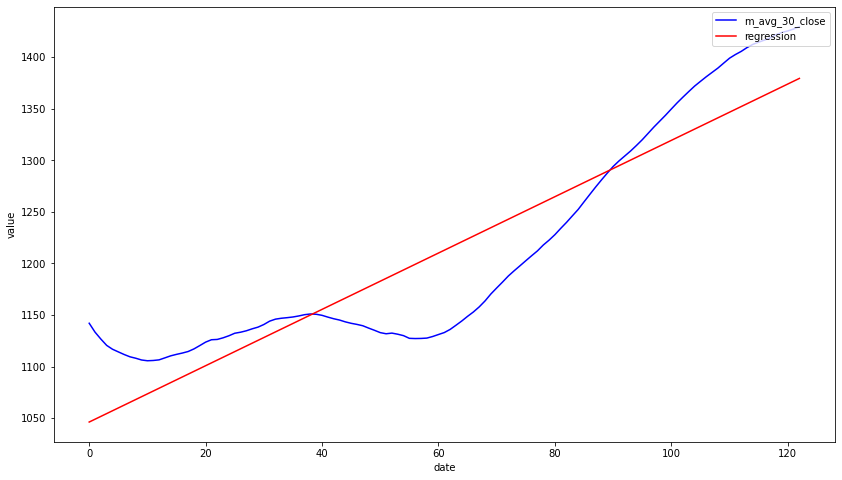

1811


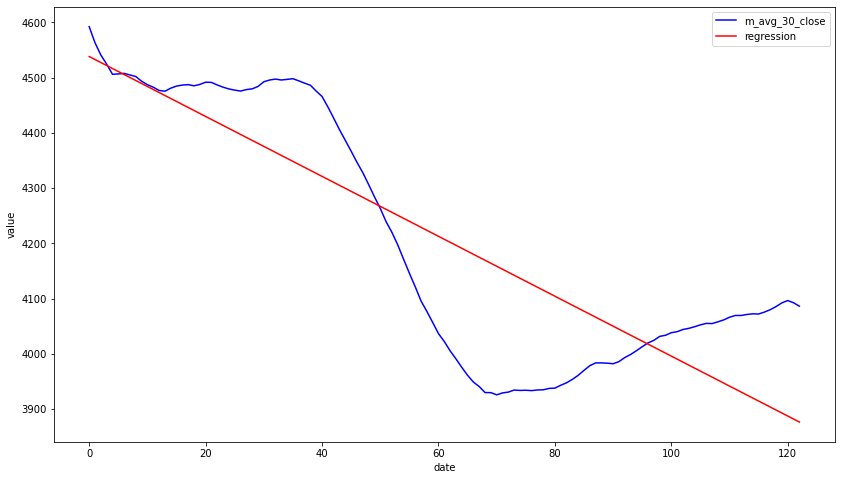

1888


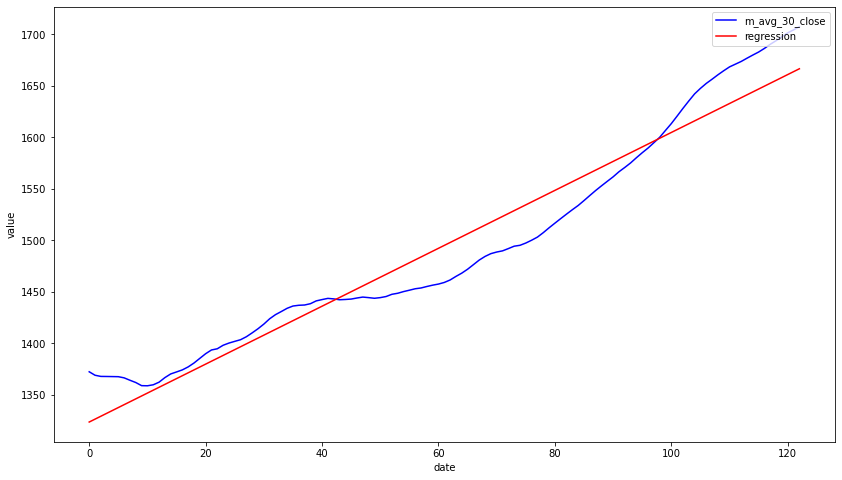

1965


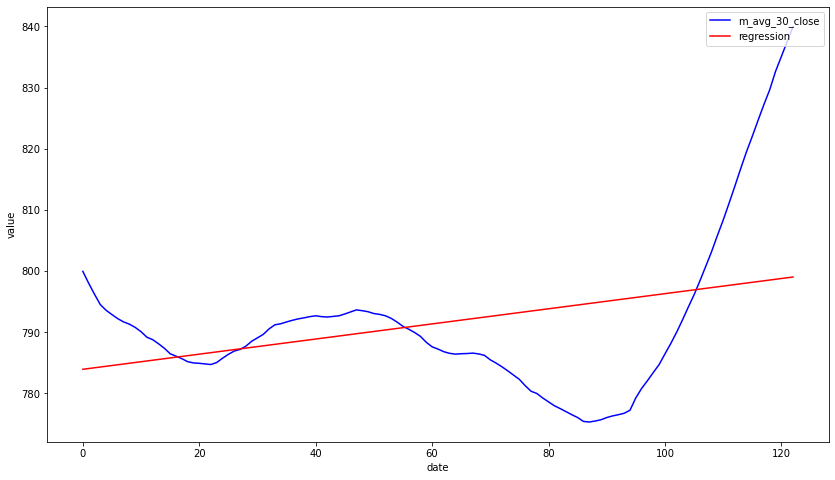

1968


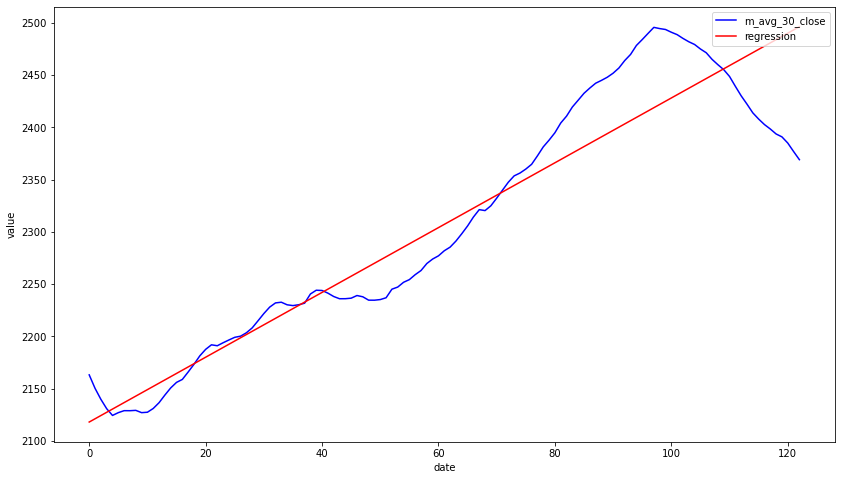

2109


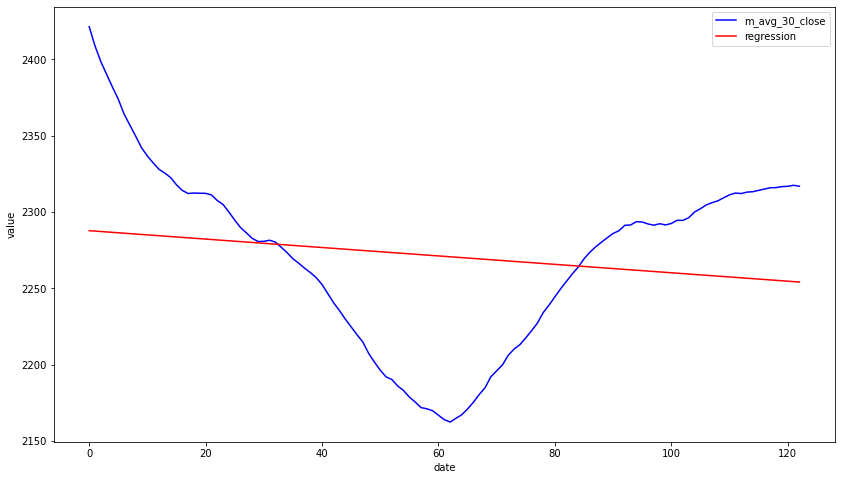

2117


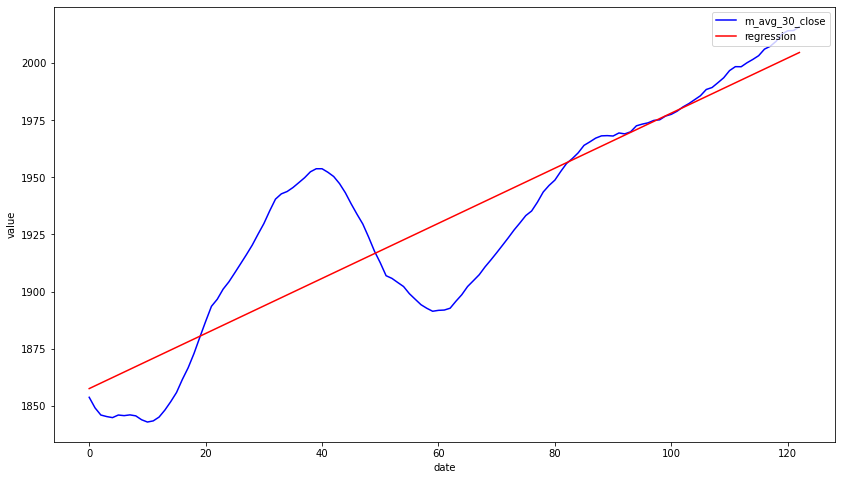

2138


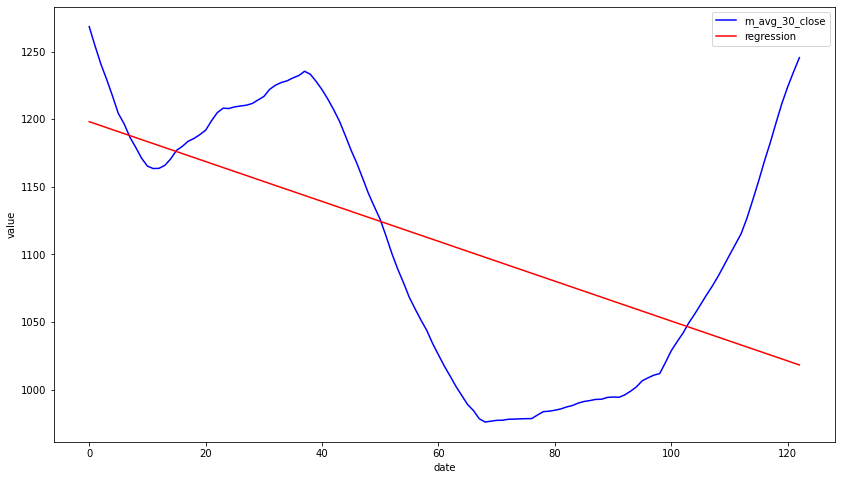

2206


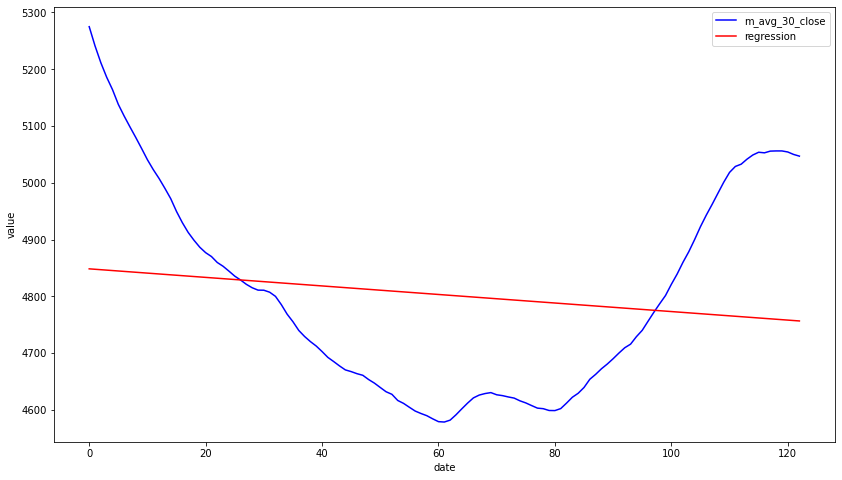

2211


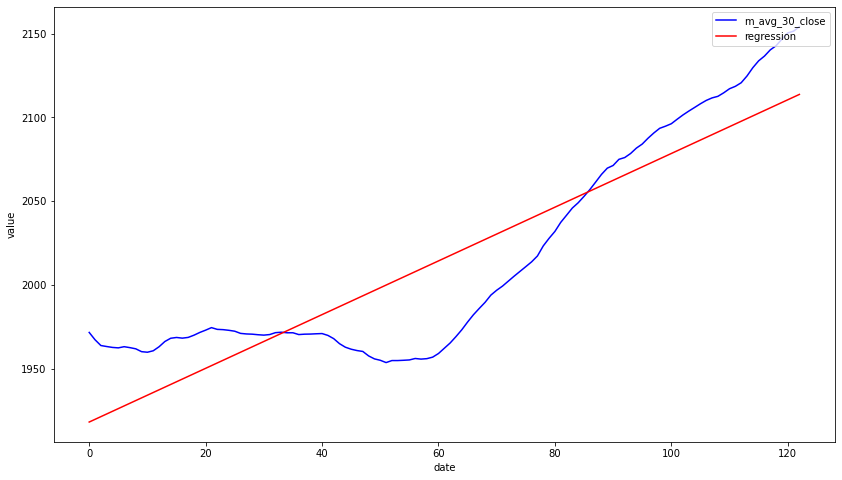

2345


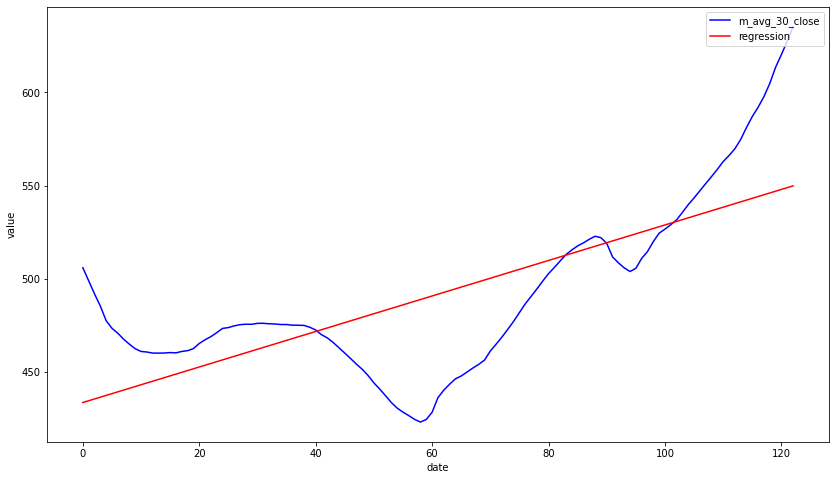

2393


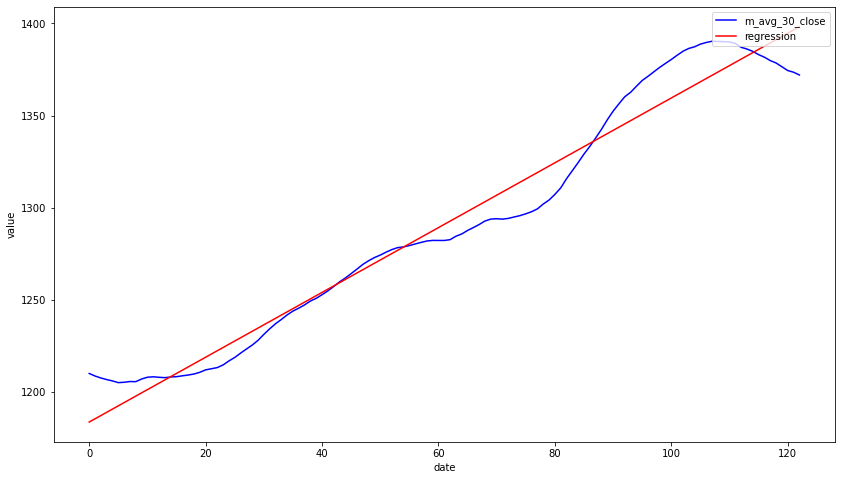

2612


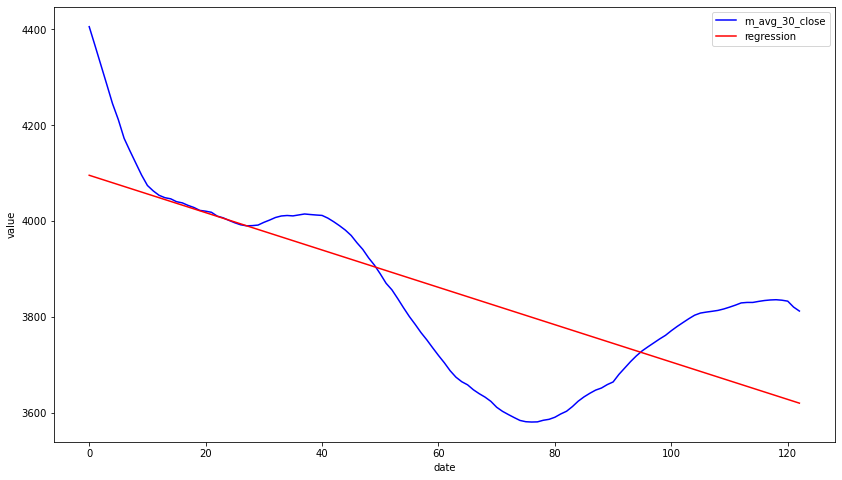

2651


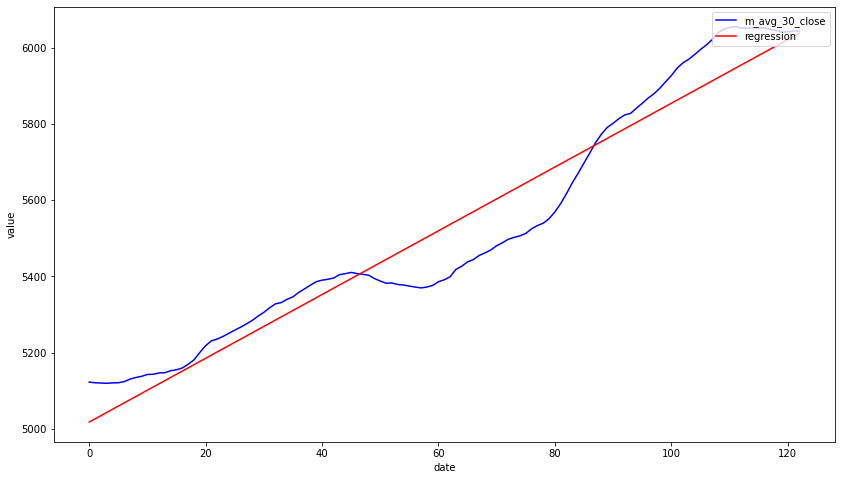

2687


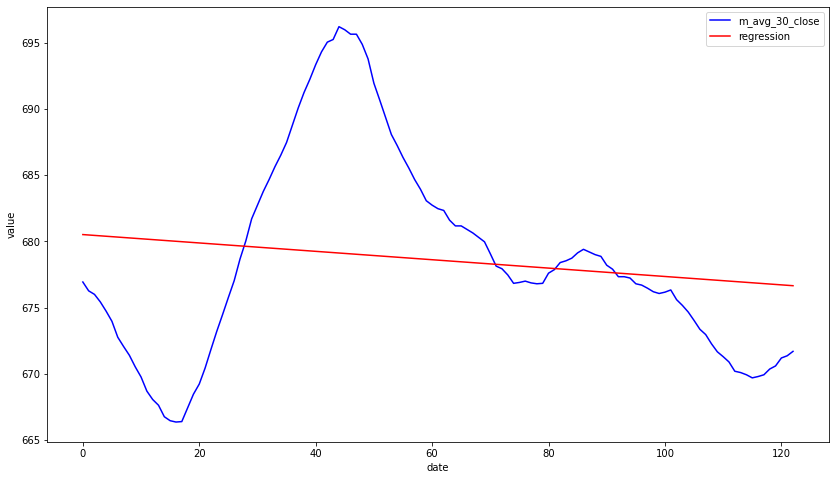

2767


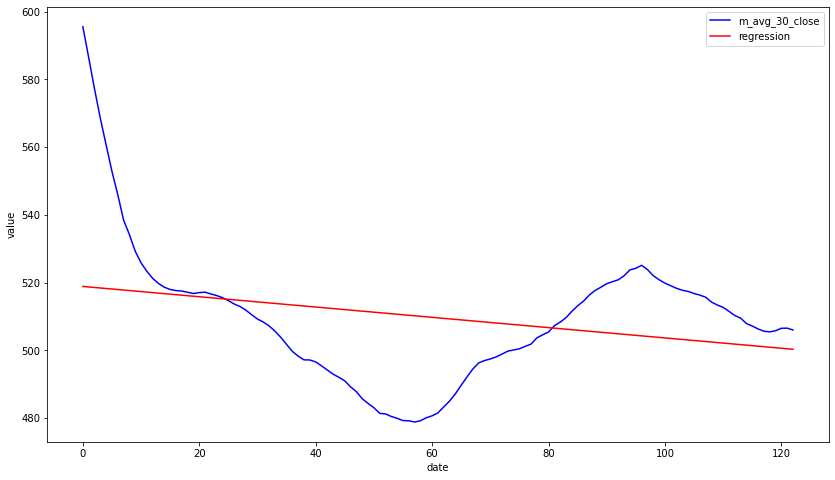

2768


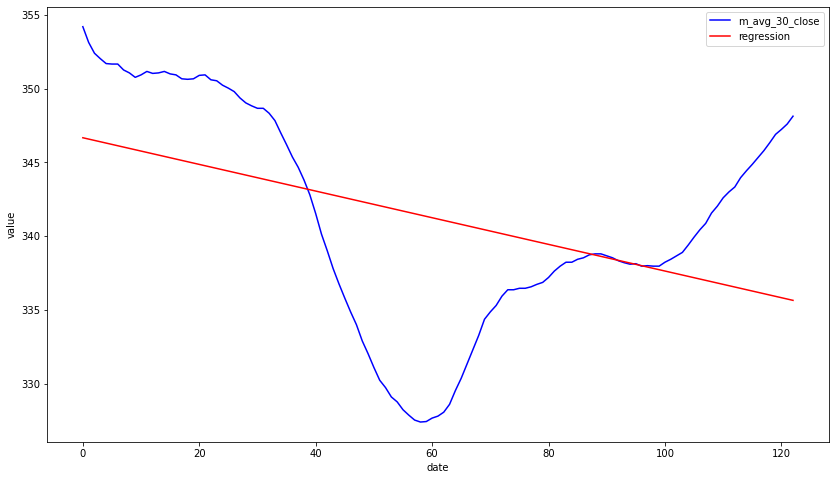

2811


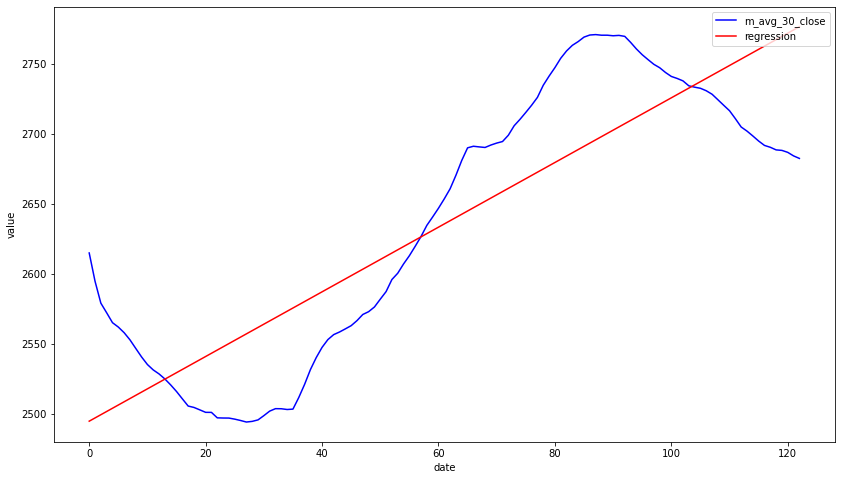

2910


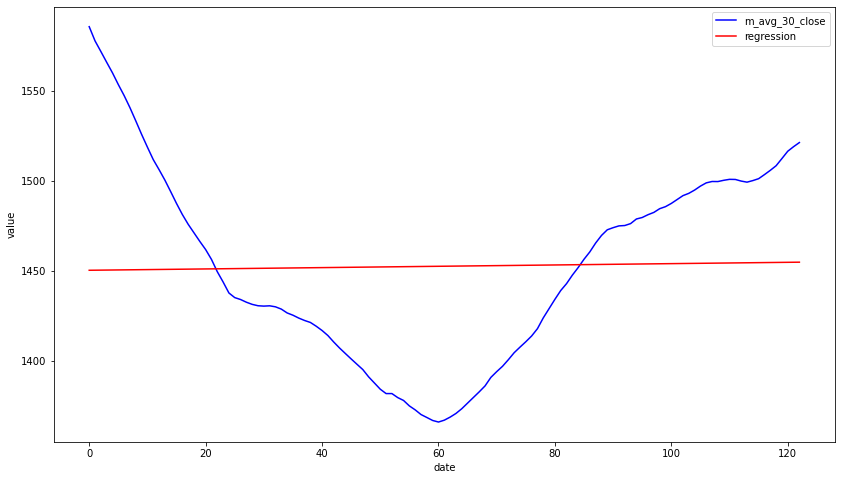

3003


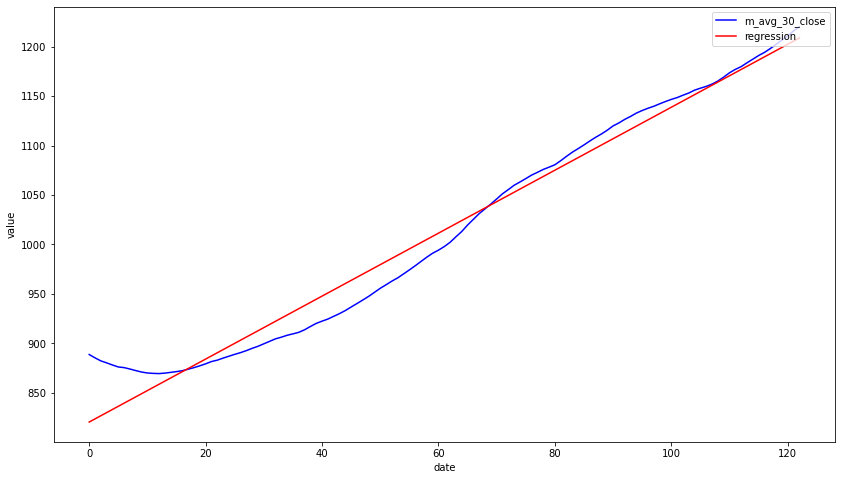

3059


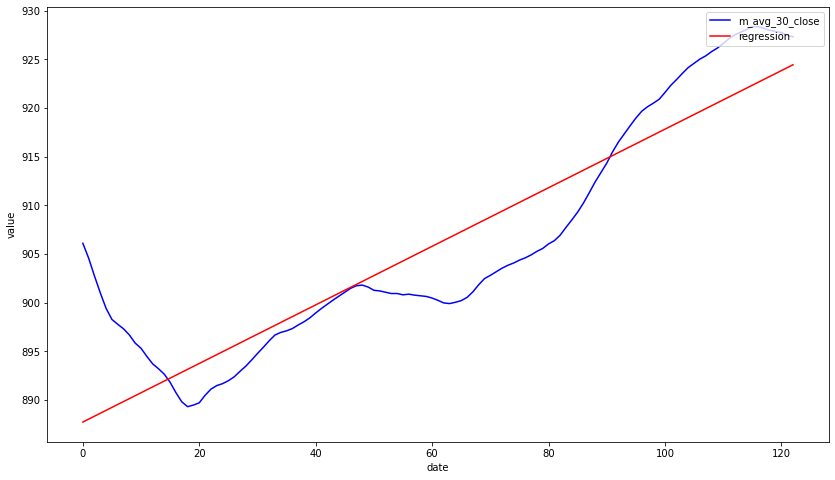

3099


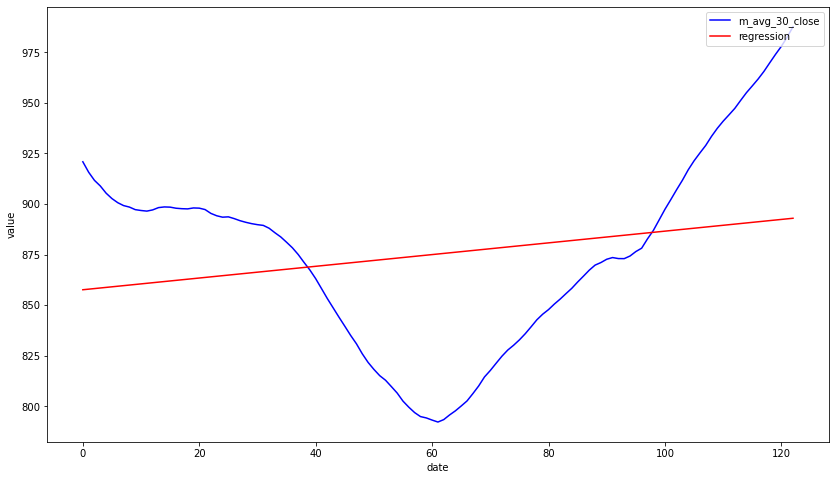

3116


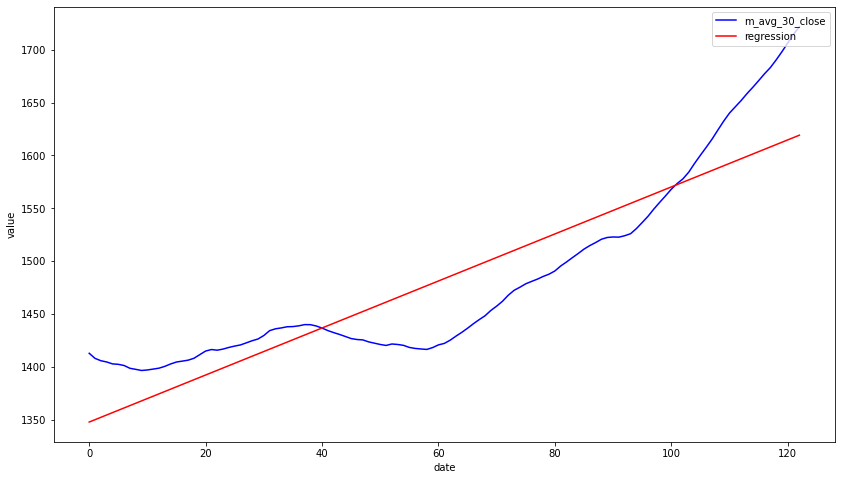

3156


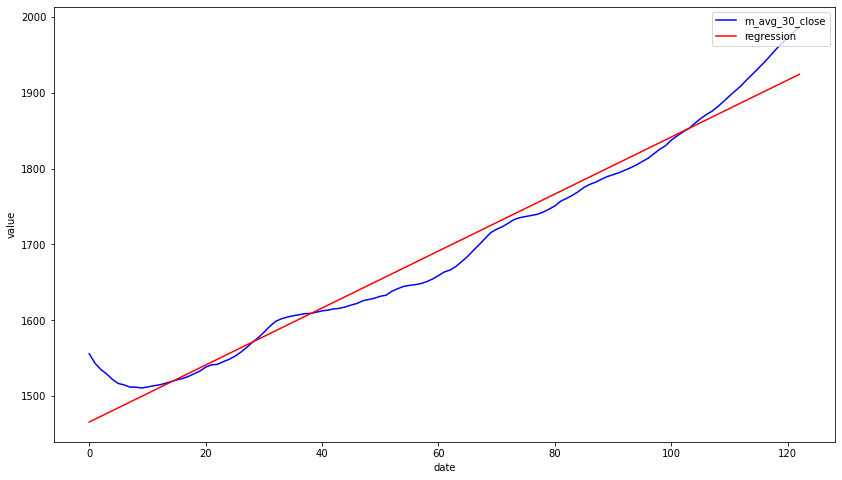

3267


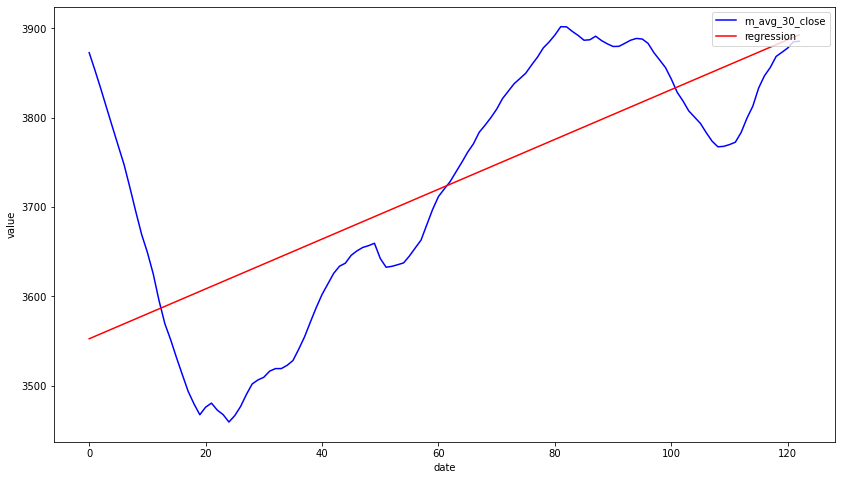

3291


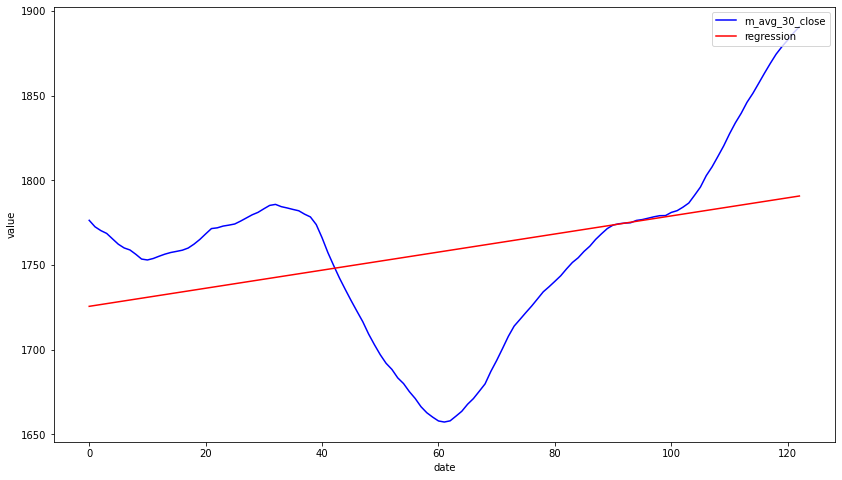

3388


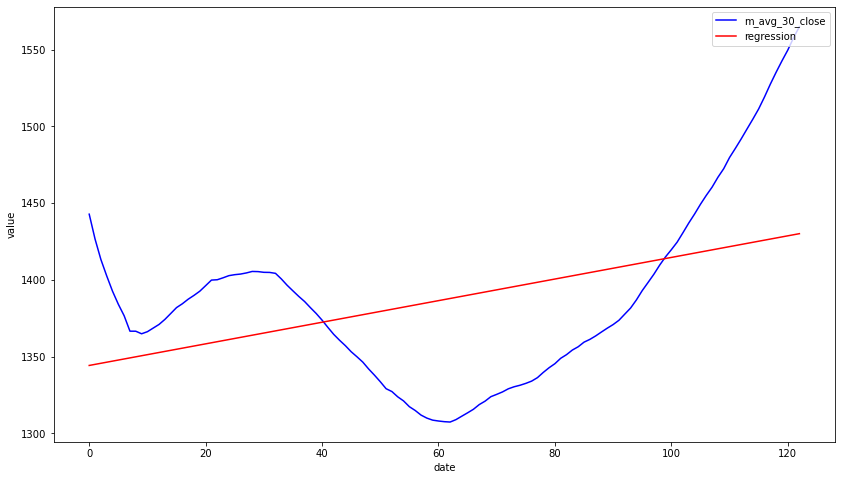

3447


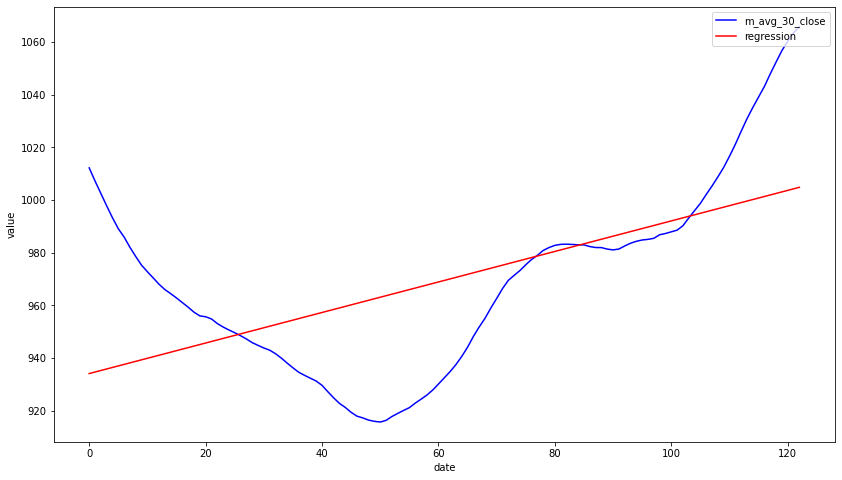

3747


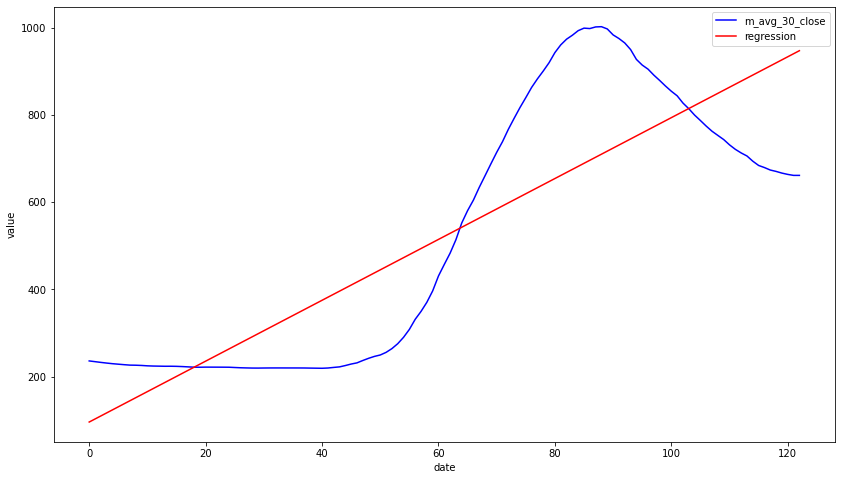

3979


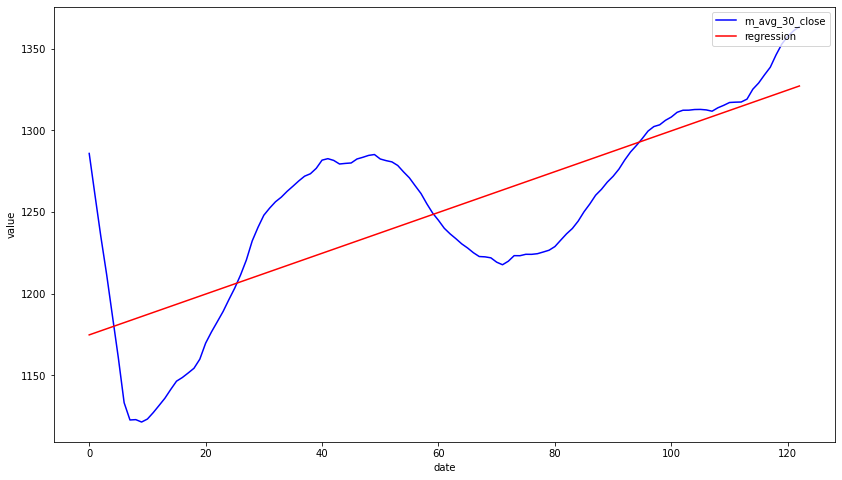

3989


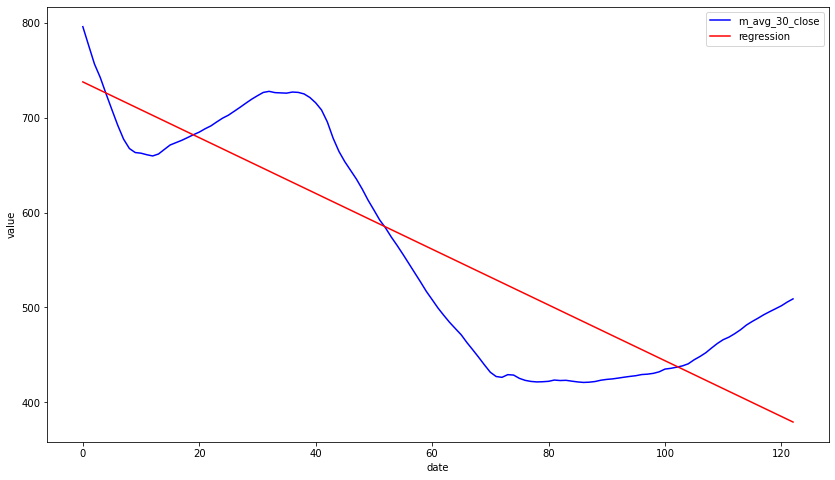

4031


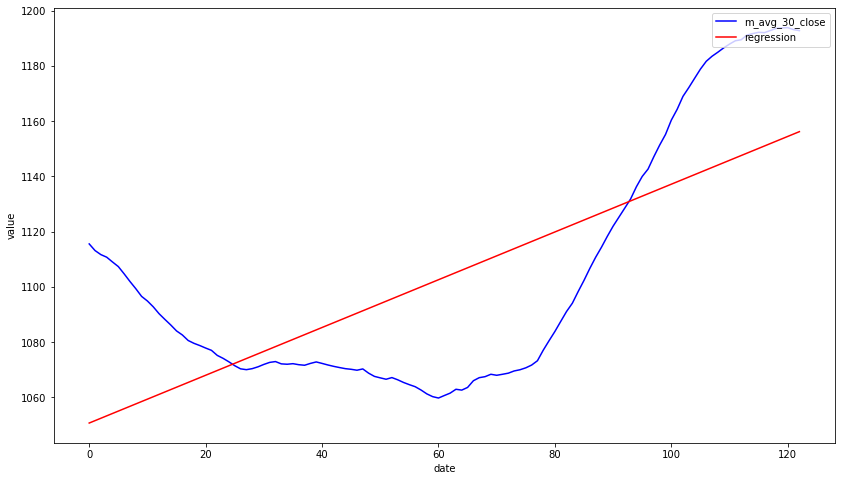

4113


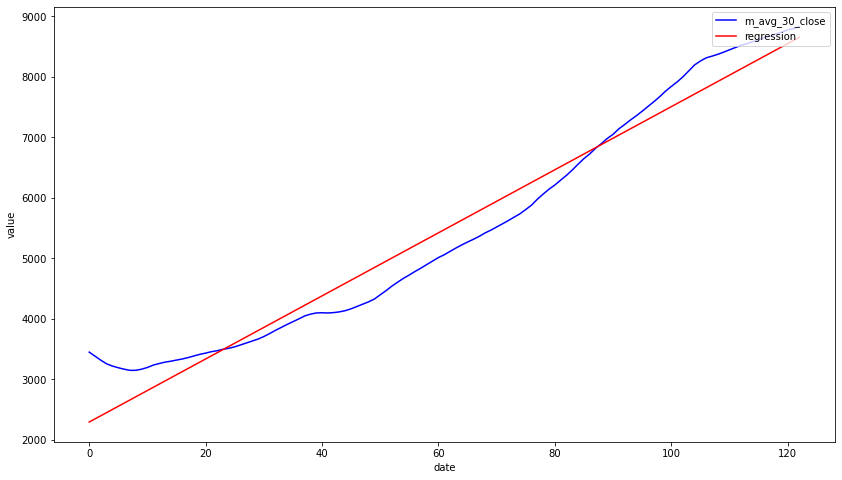

4202


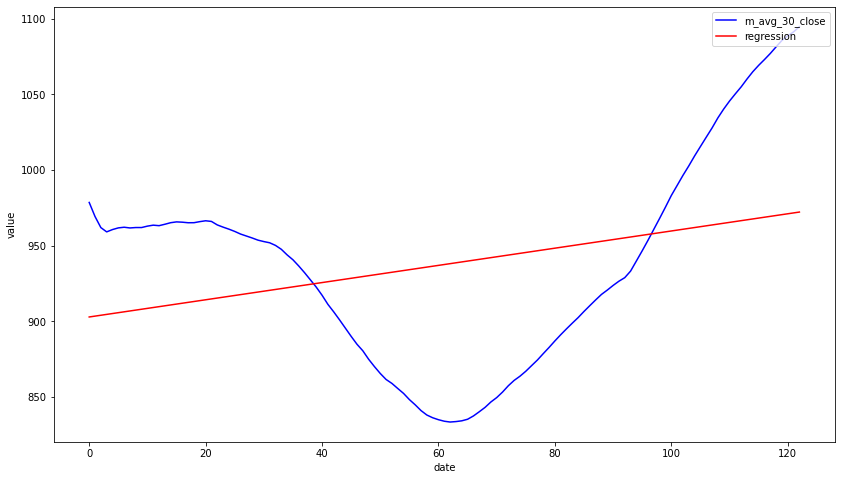

4324


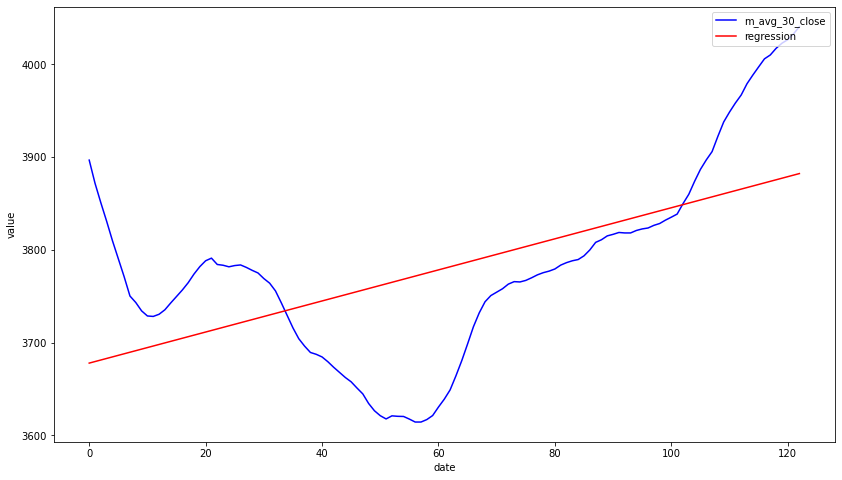

4502


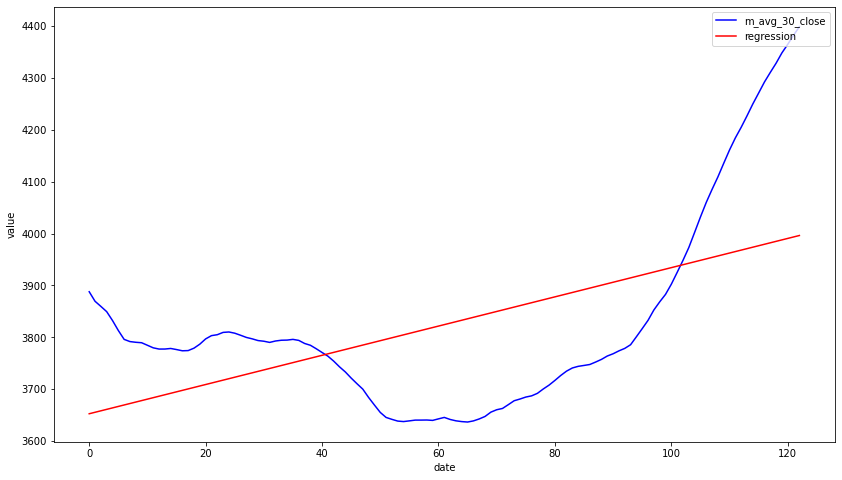

4538


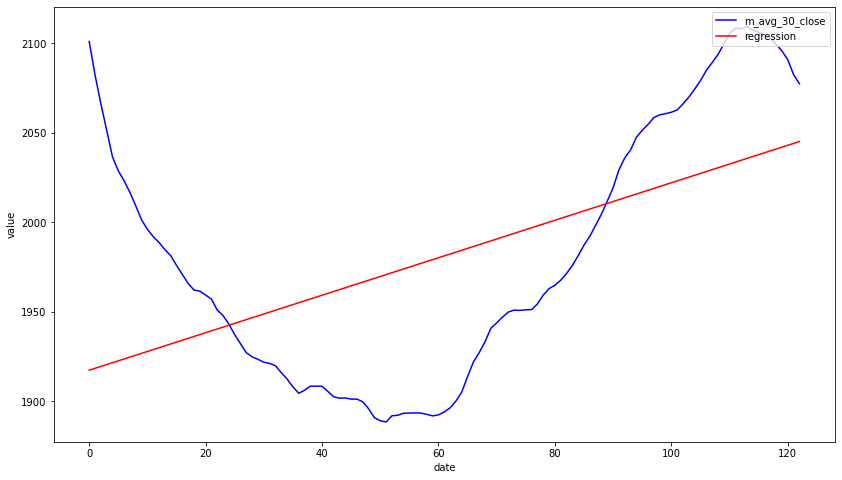

4541


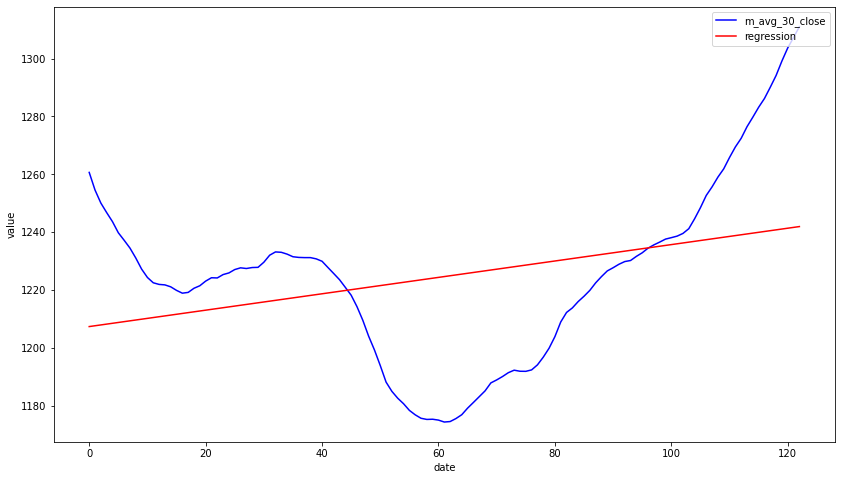

4549


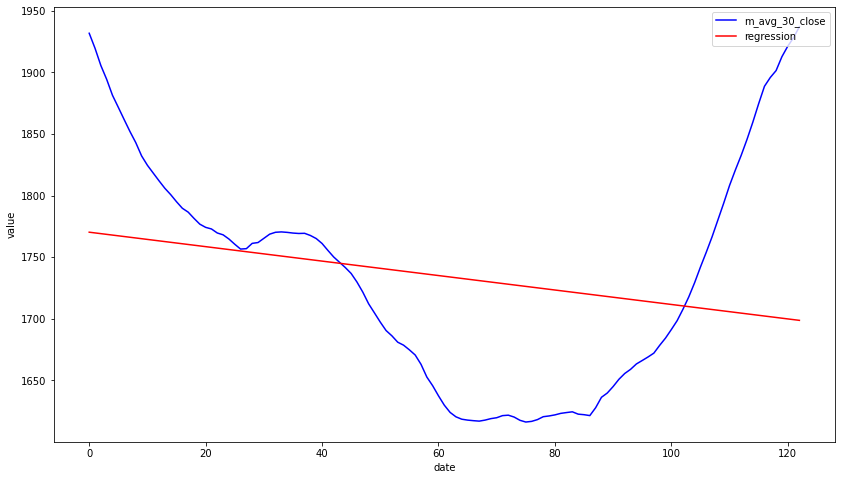

4554


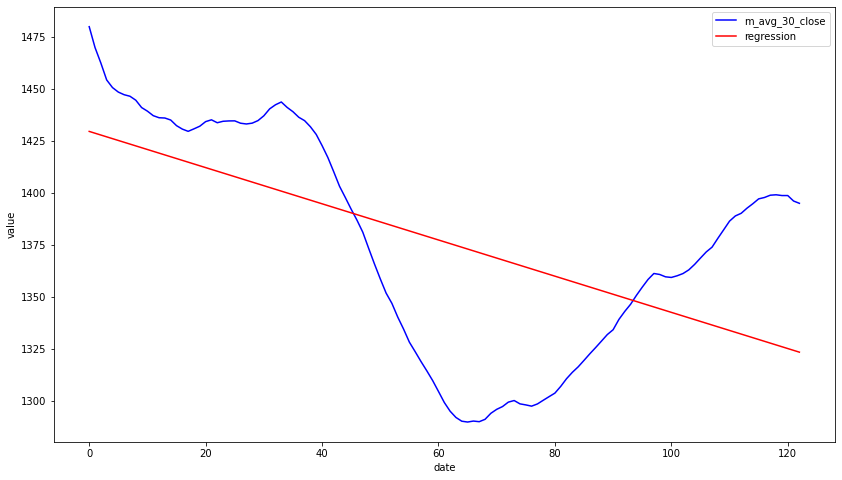

4564


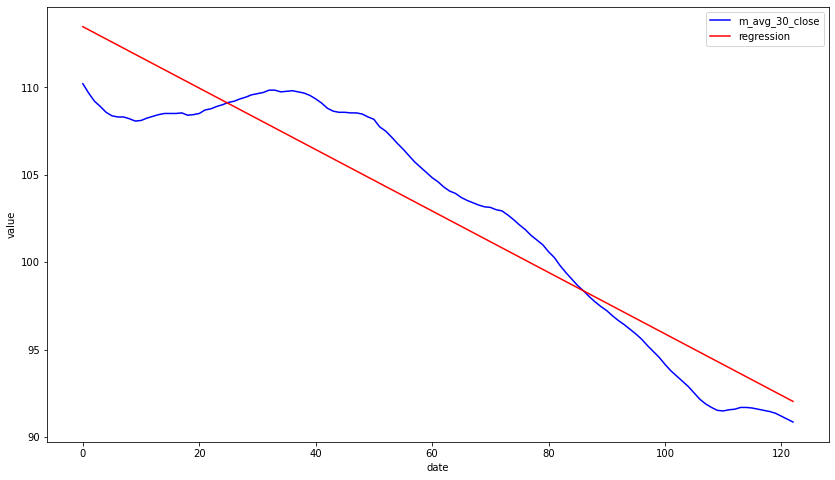

4581


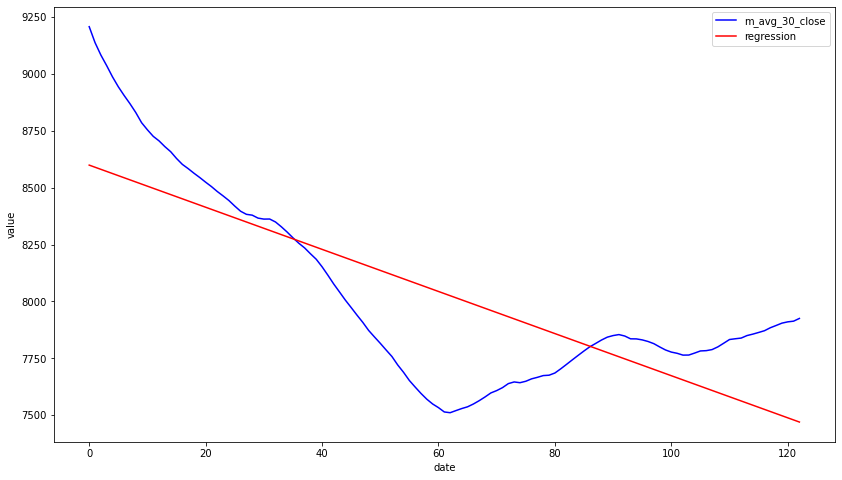

4584


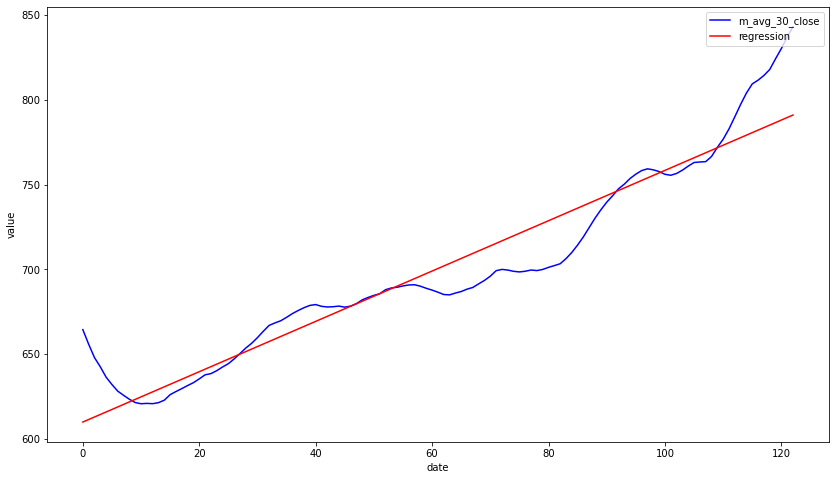

4623


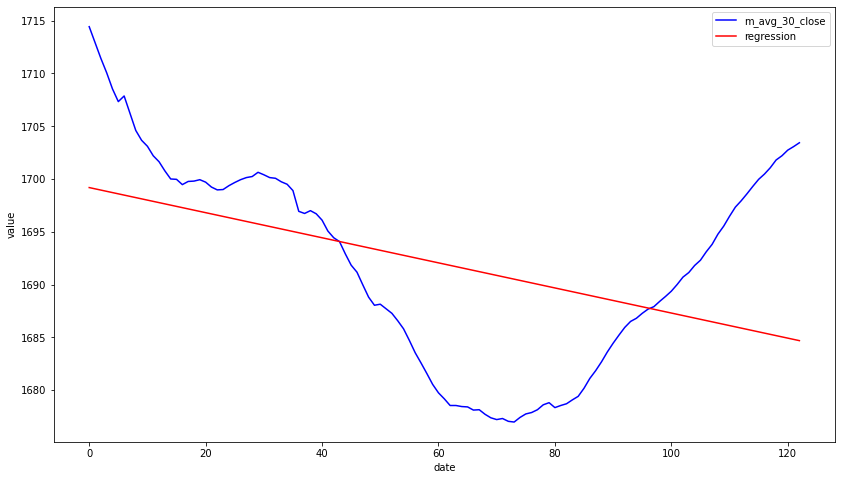

4631


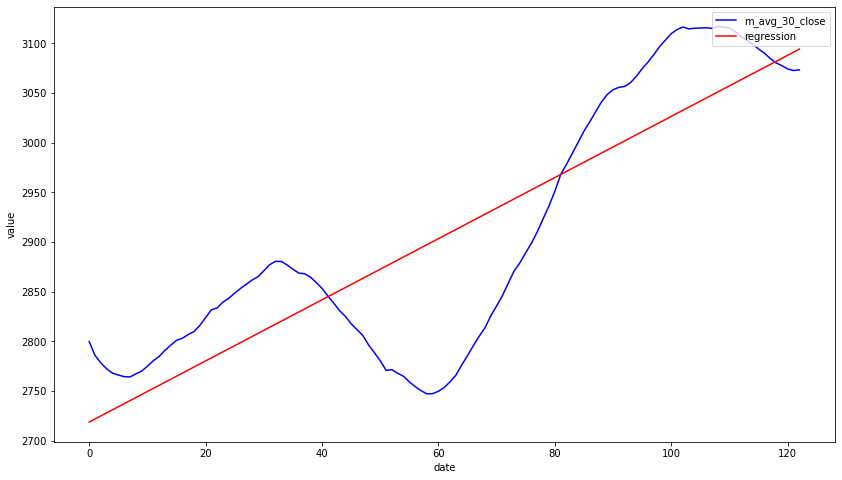

4678


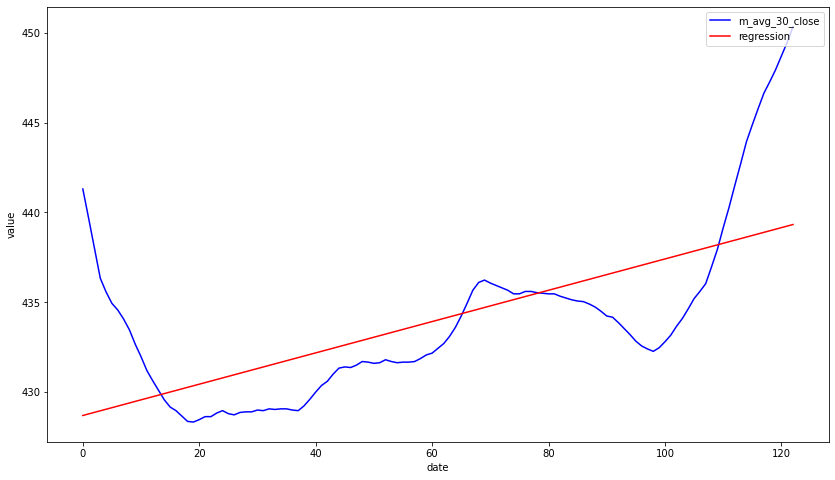

4837


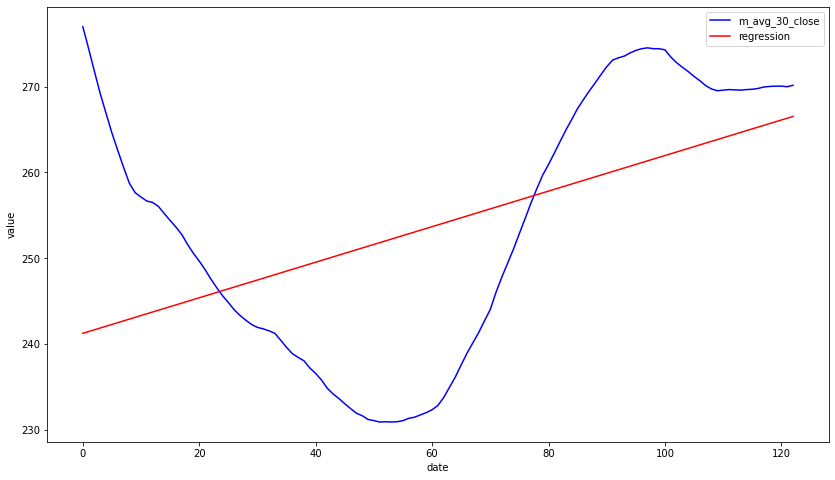

4914


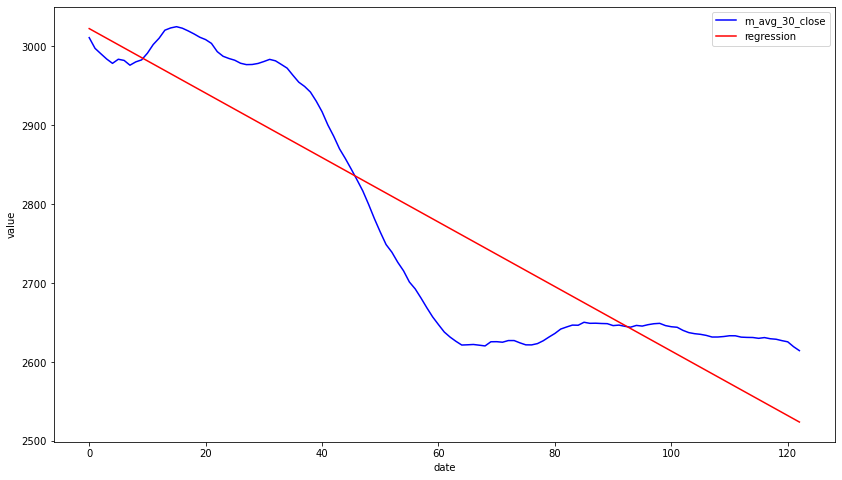

4974


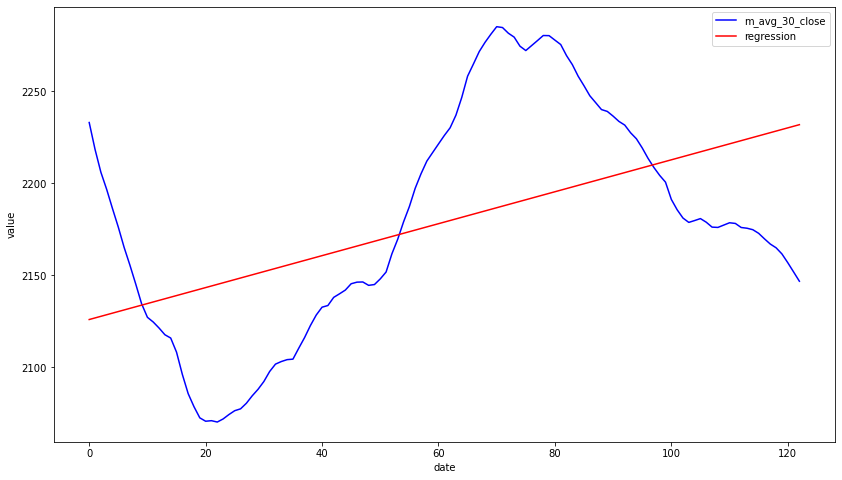

5122


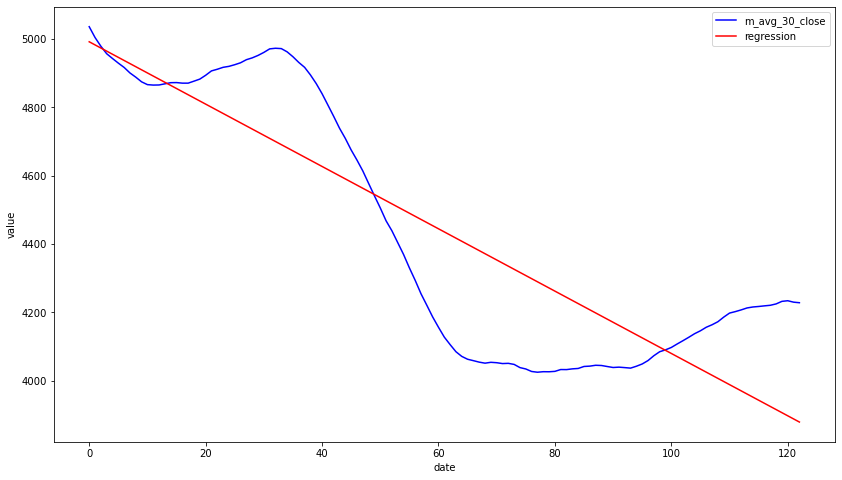

5185


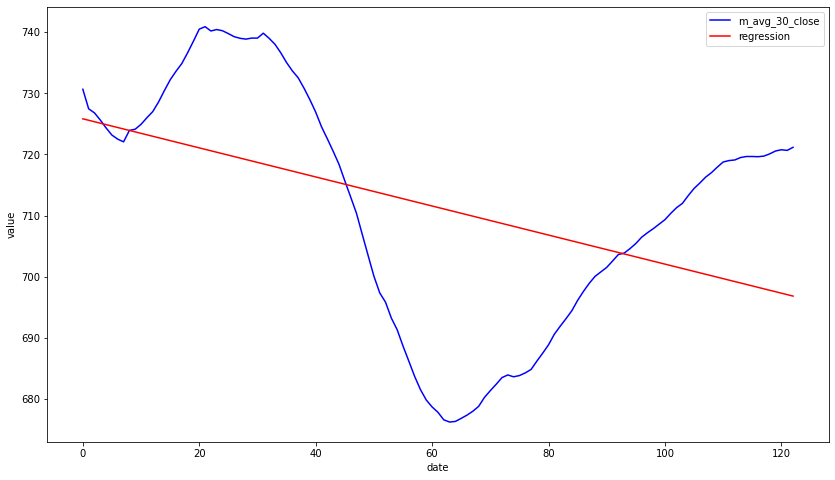

5186


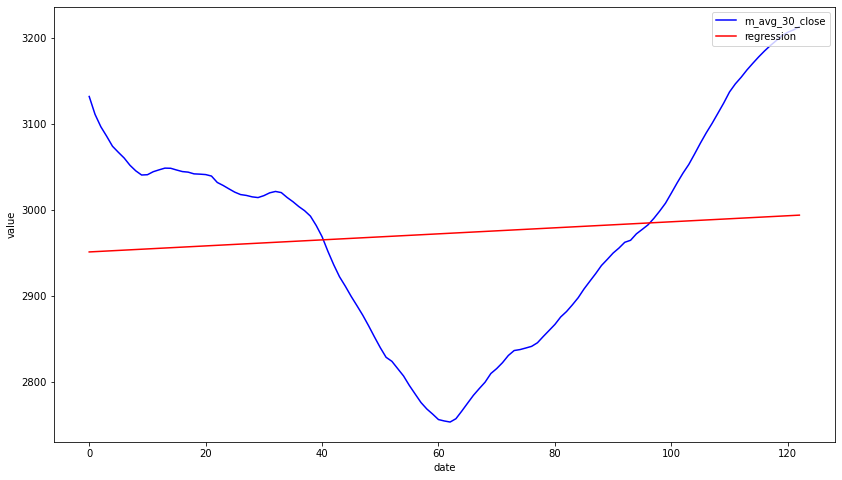

5191


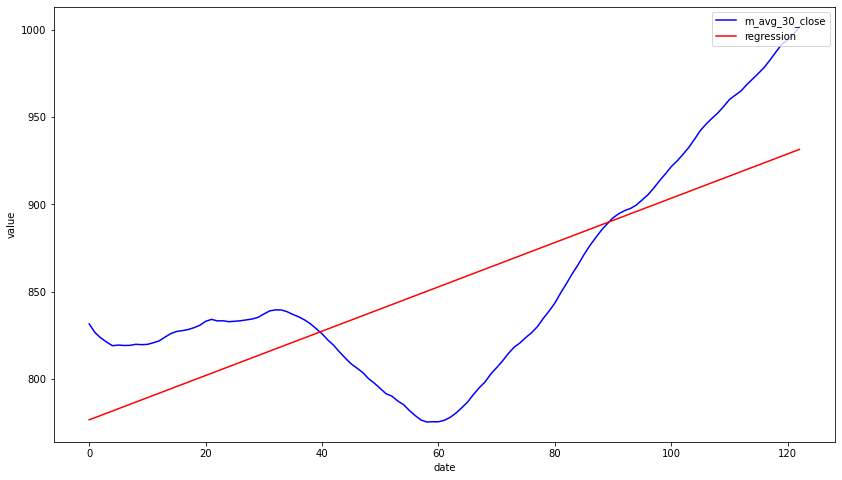

5195


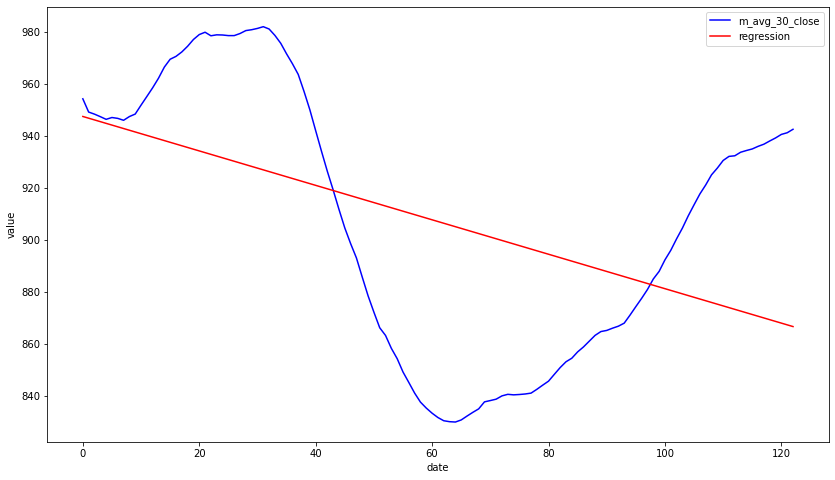

5449


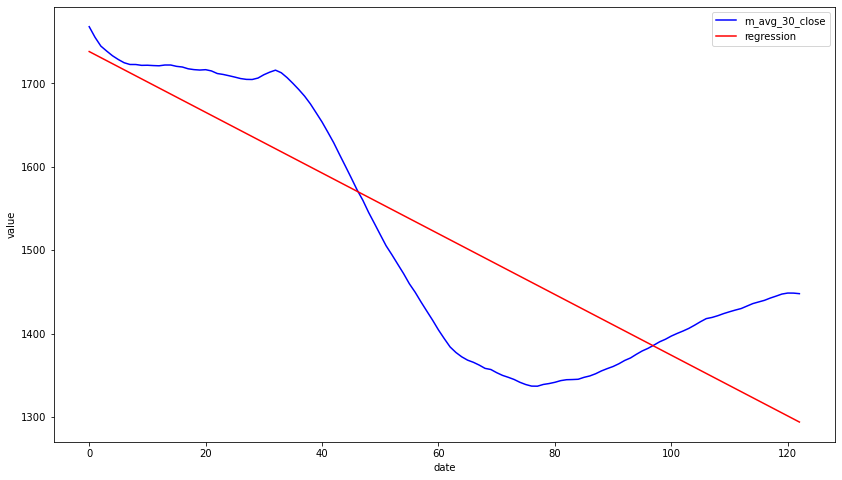

5464


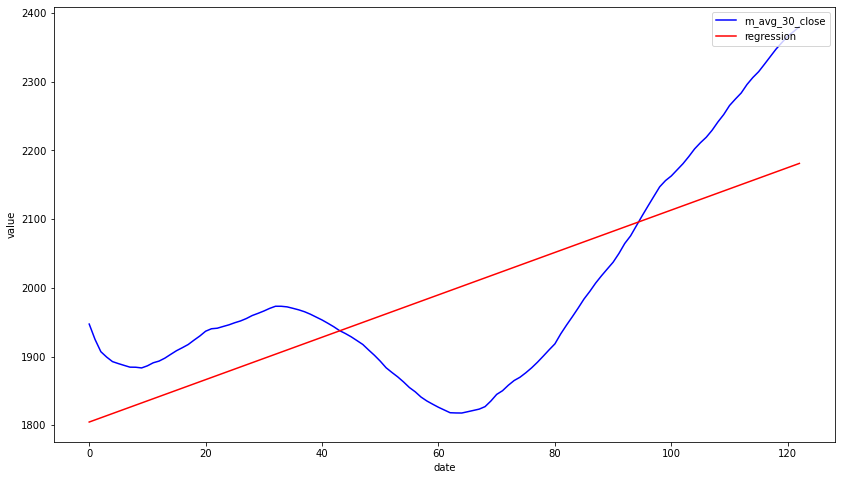

5481


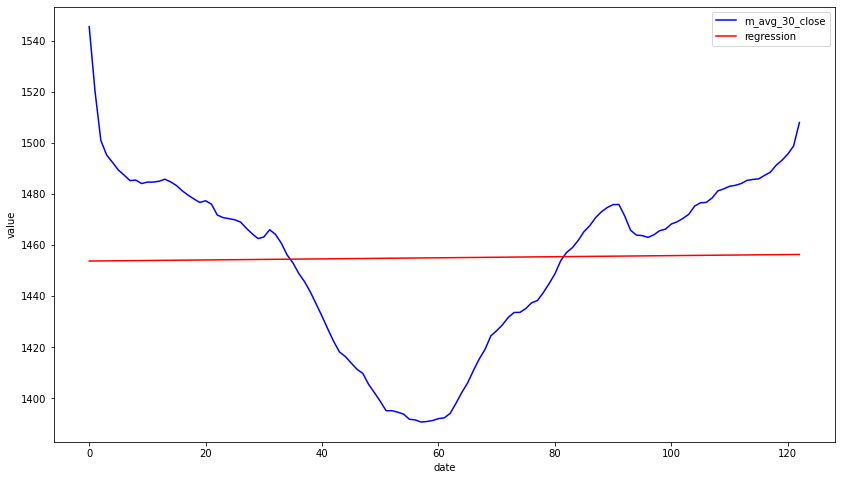

5632


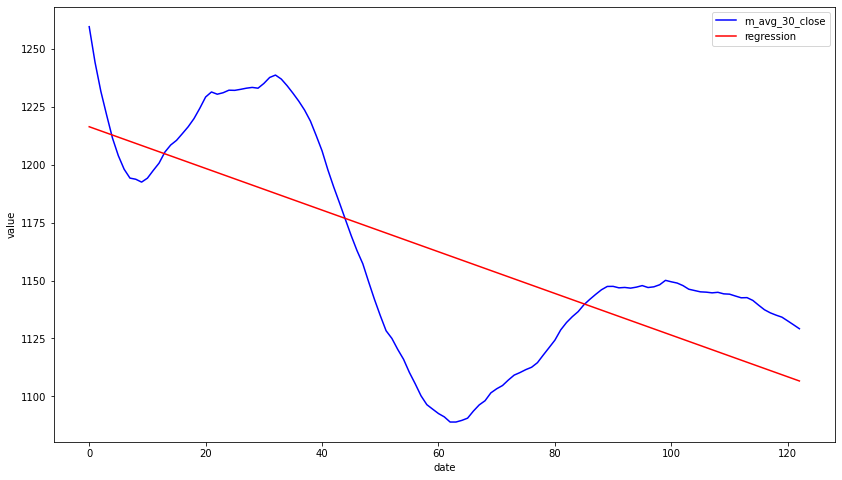

5707


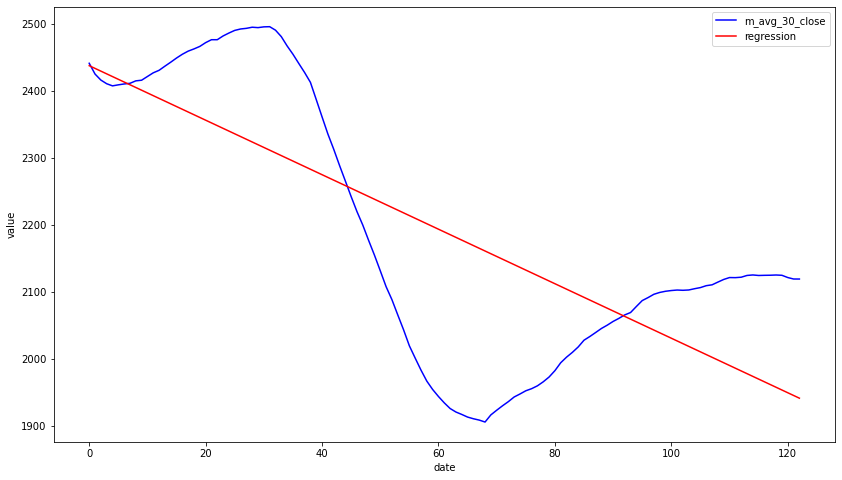

5741


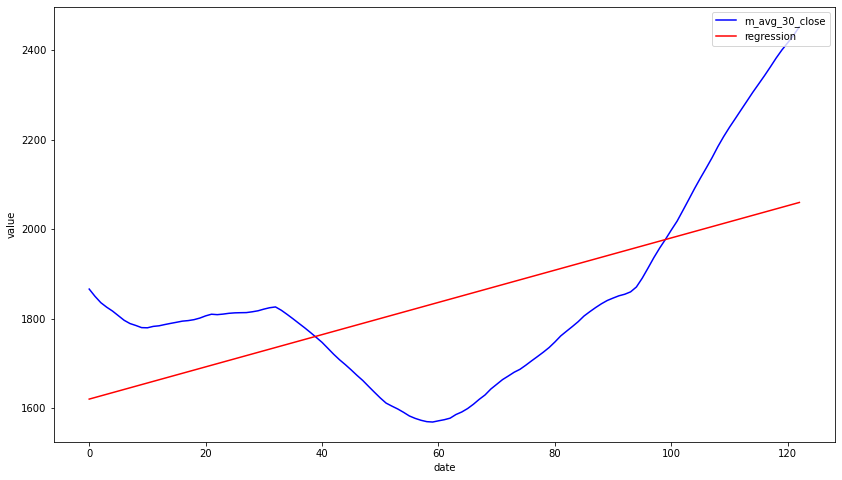

5943


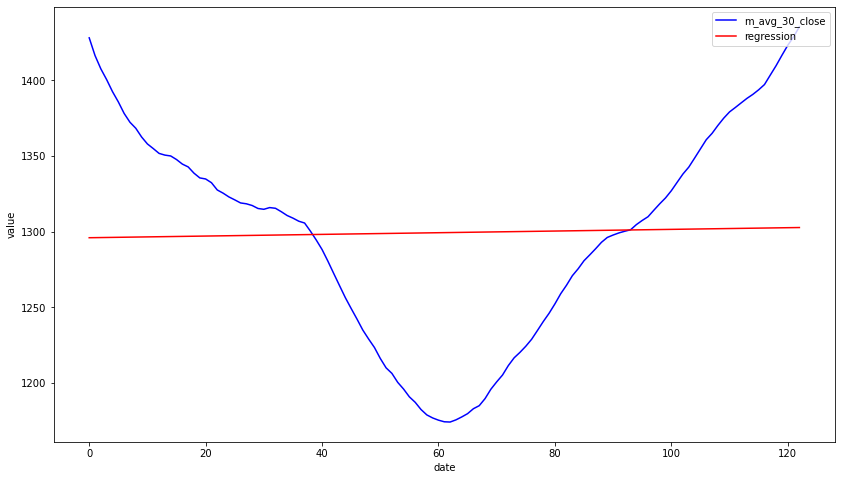

5951


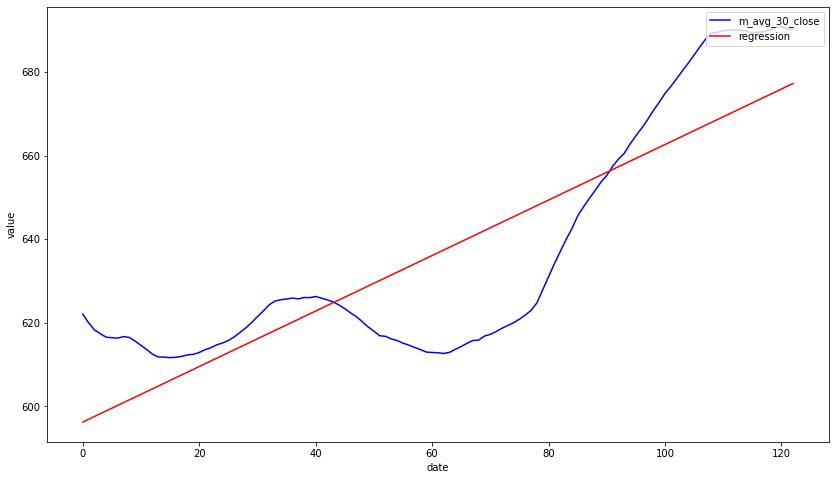

5956


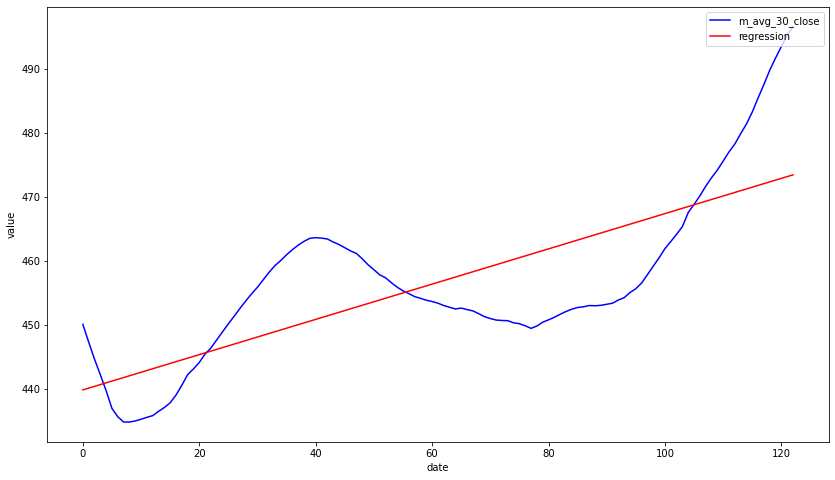

5985


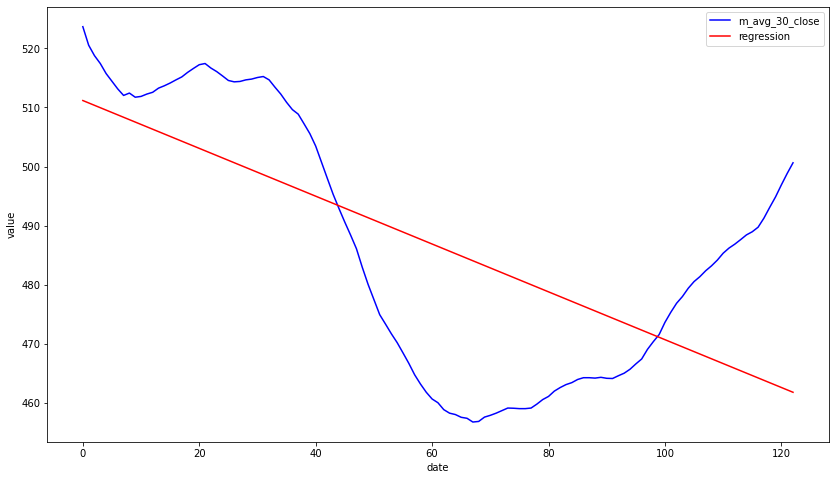

5991


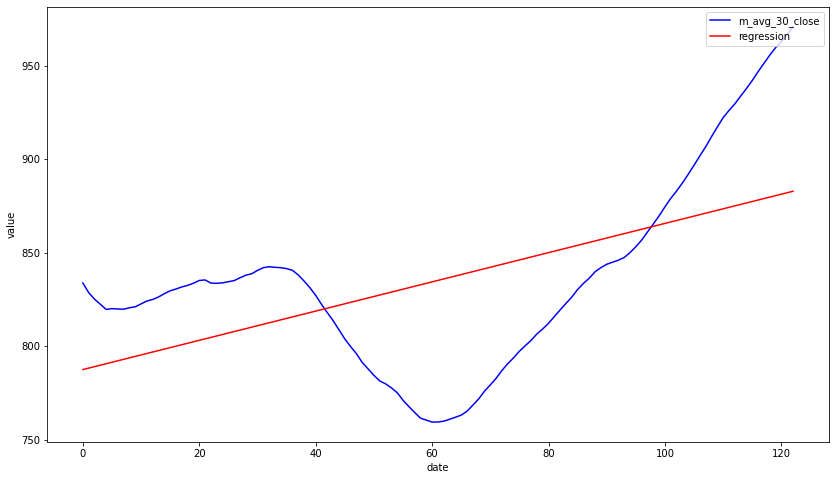

6049


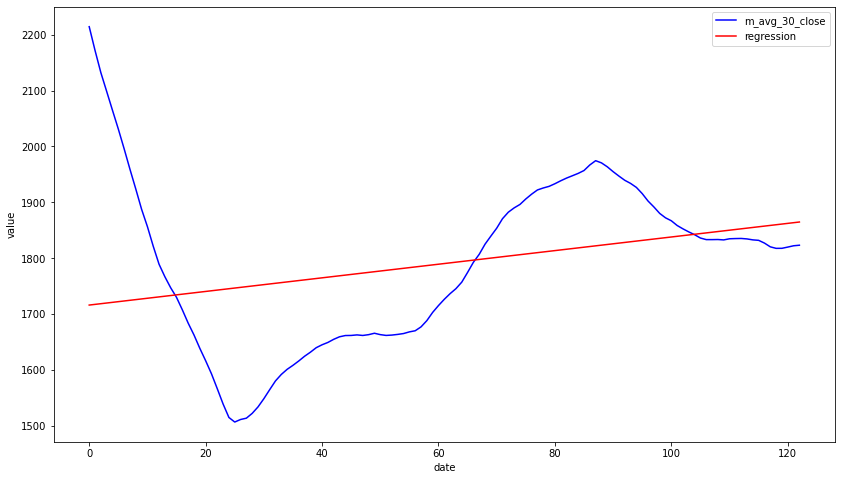

6181


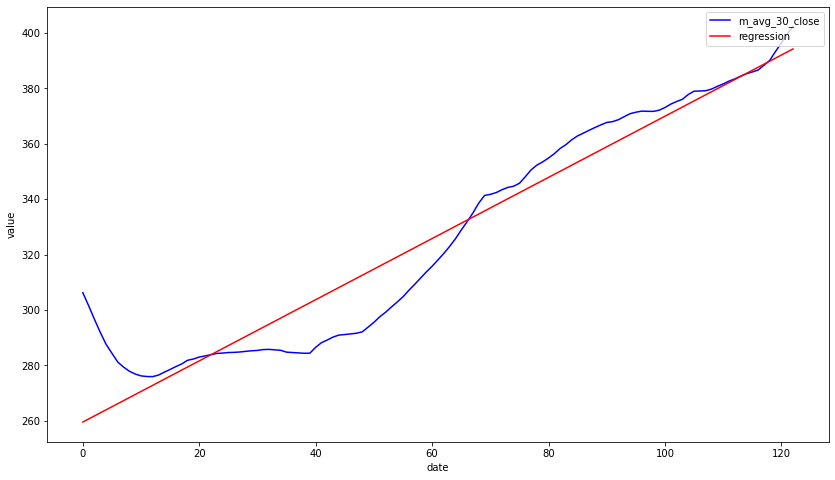

6217


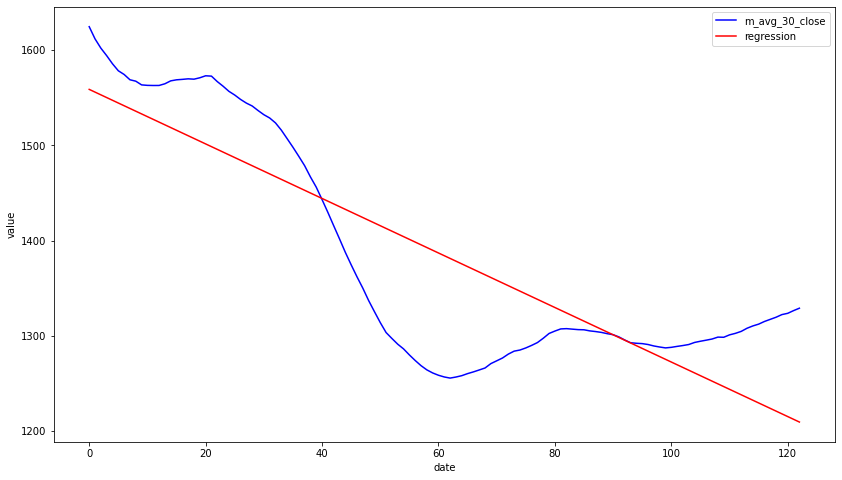

6249


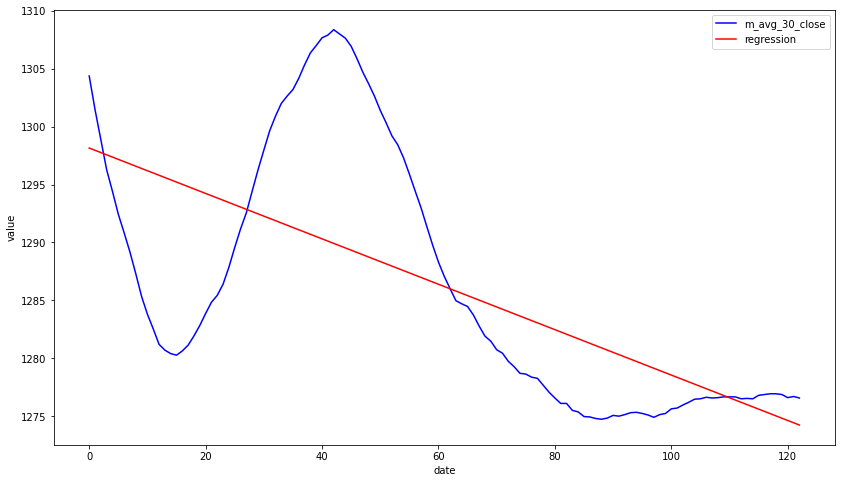

6357


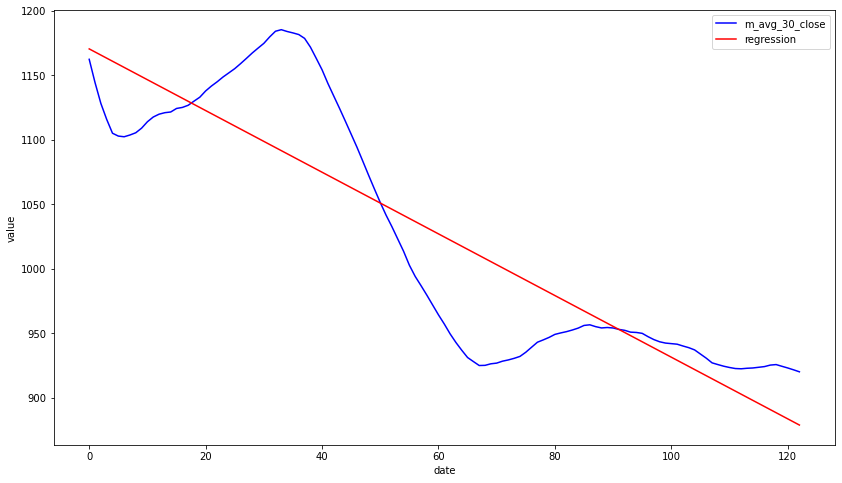

6390


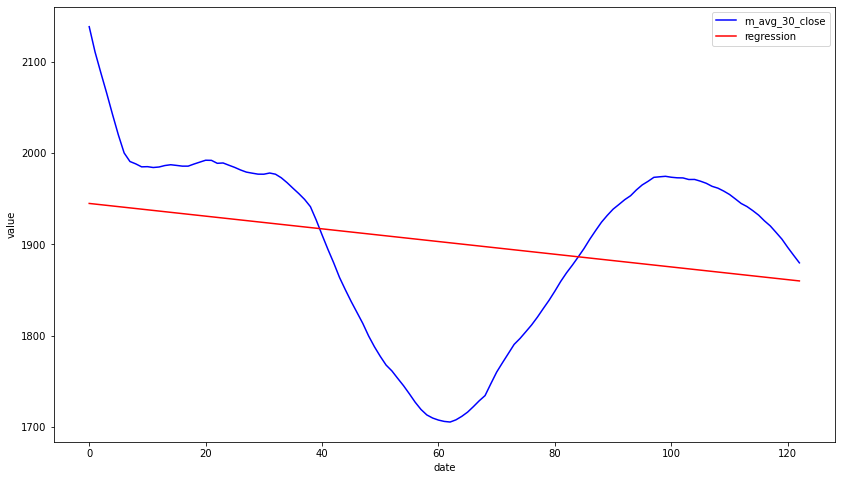

6462


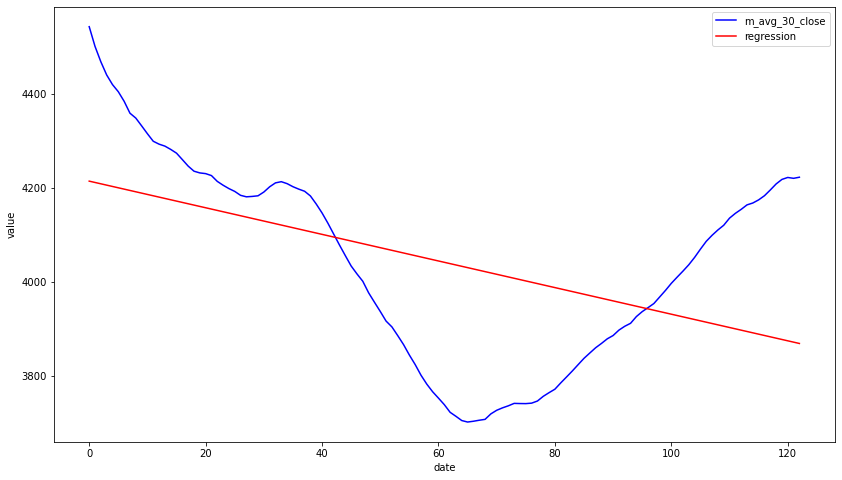

6463


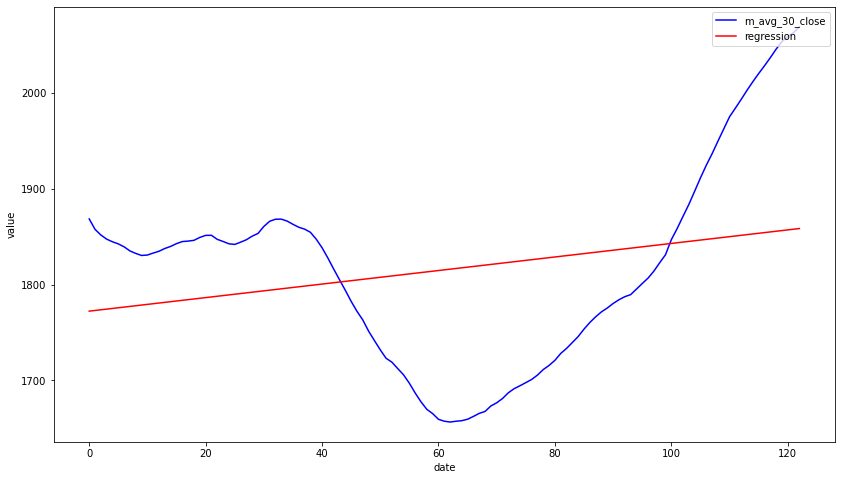

6490


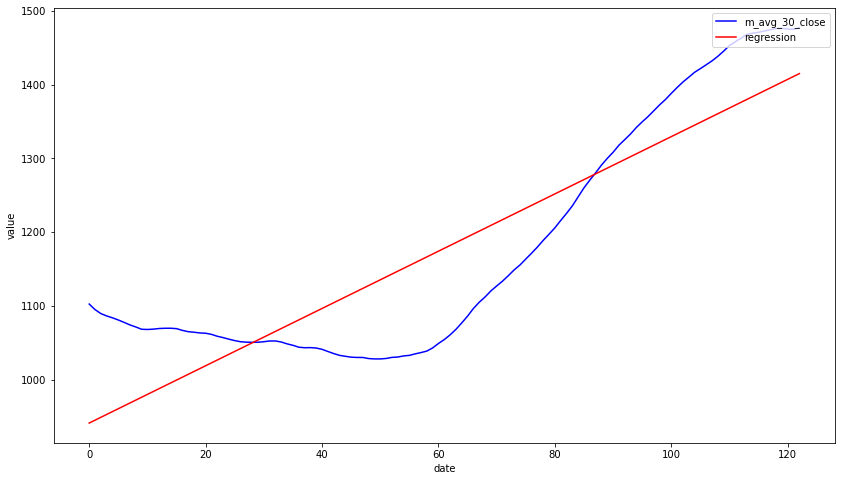

6498


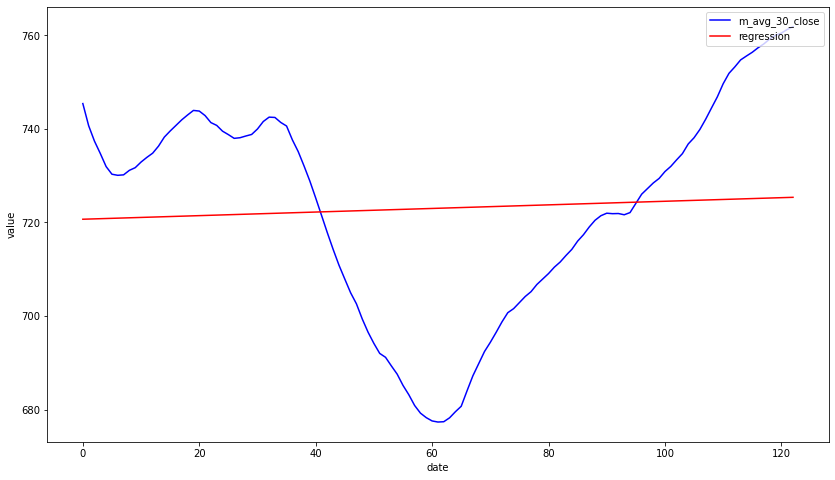

6553


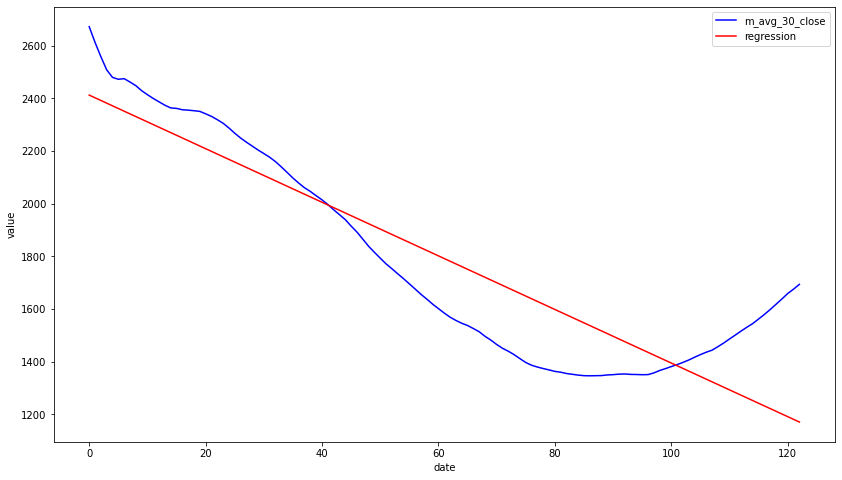

6590


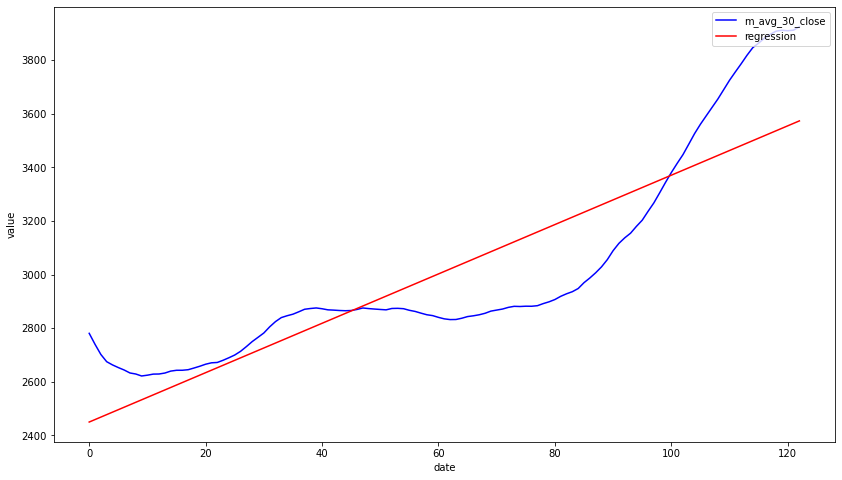

6654


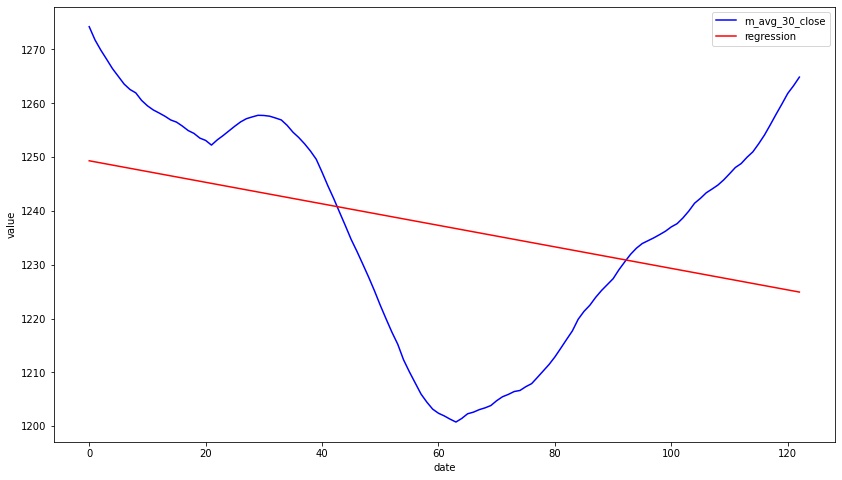

6676


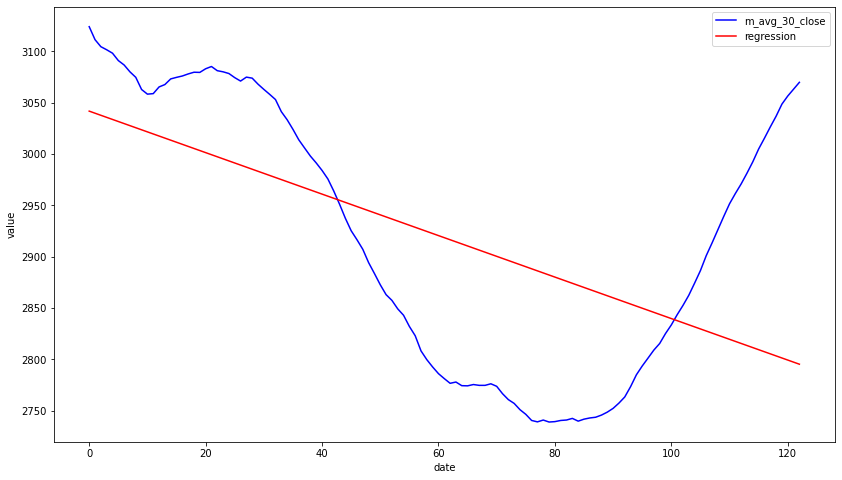

6855


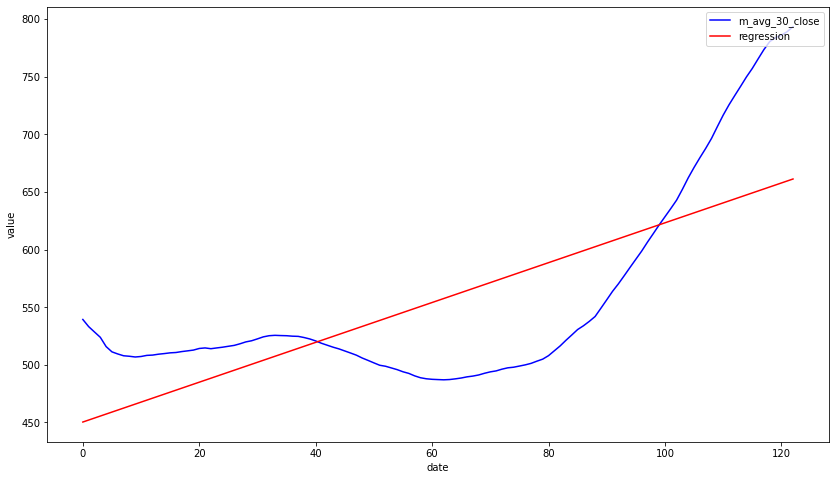

6923


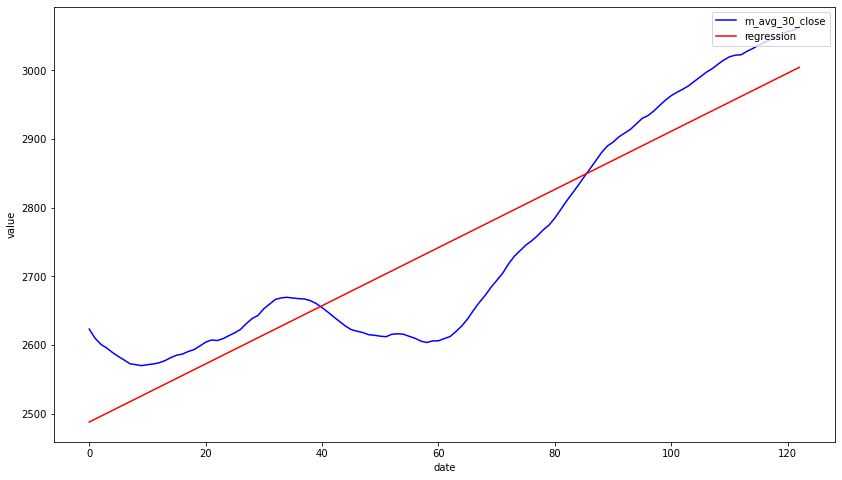

6957


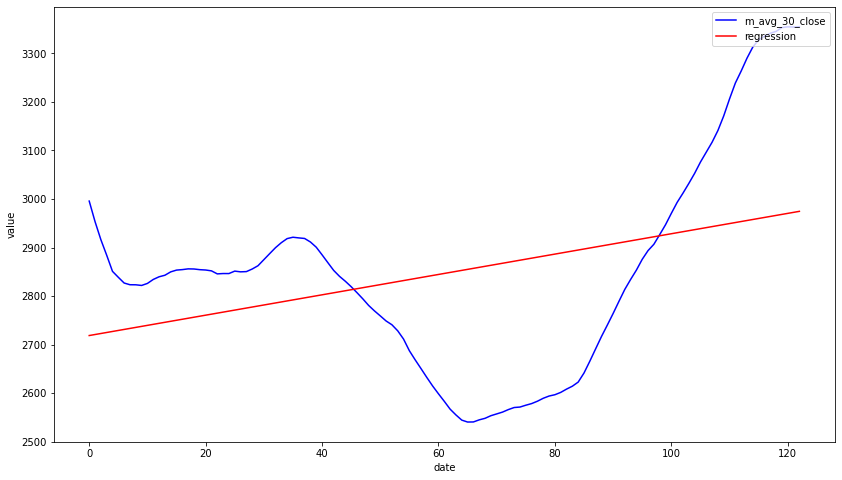

6986


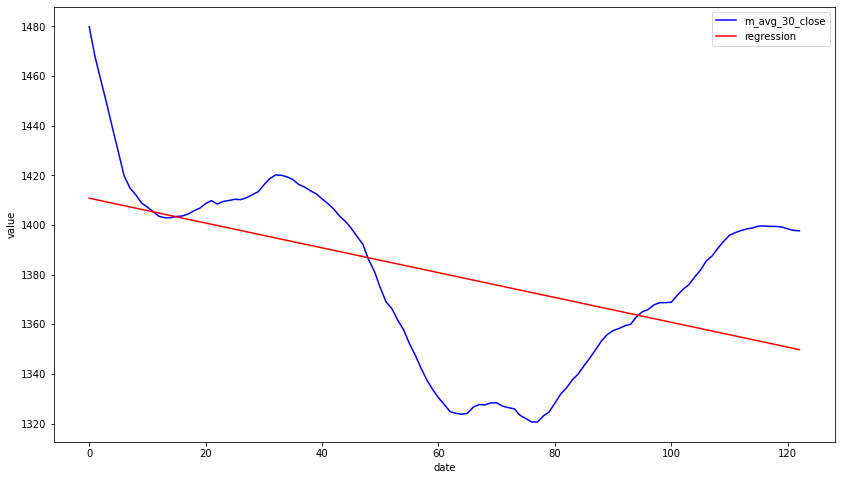

7182


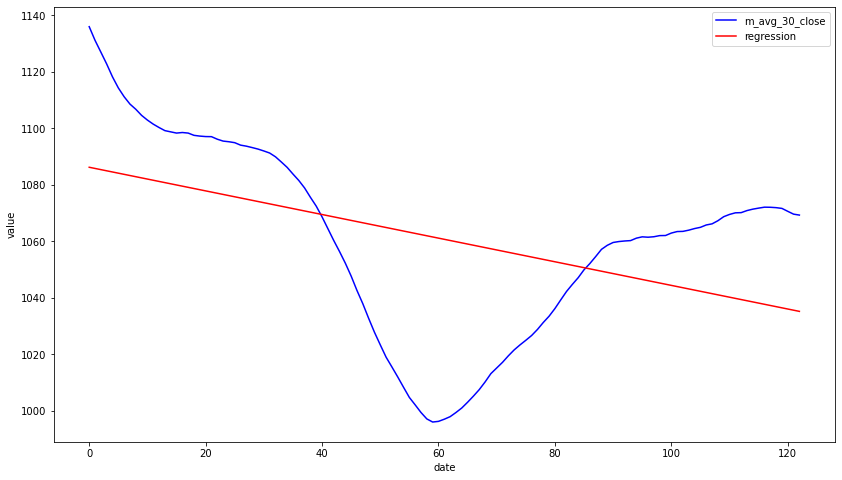

7184


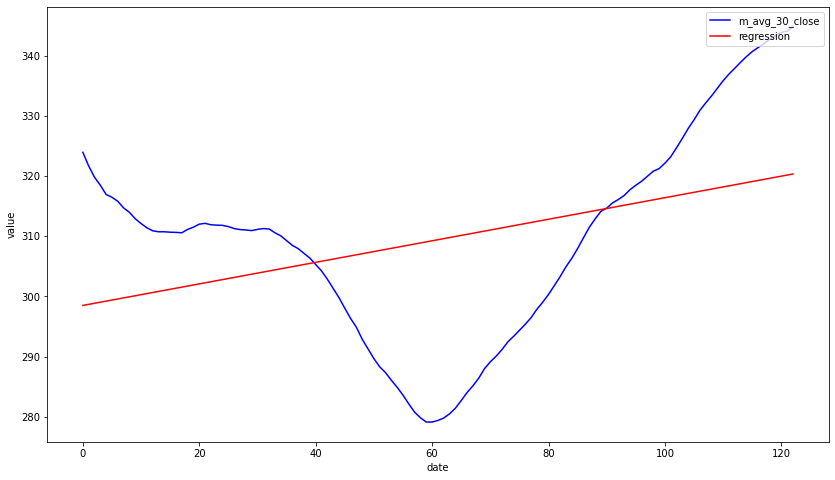

7201


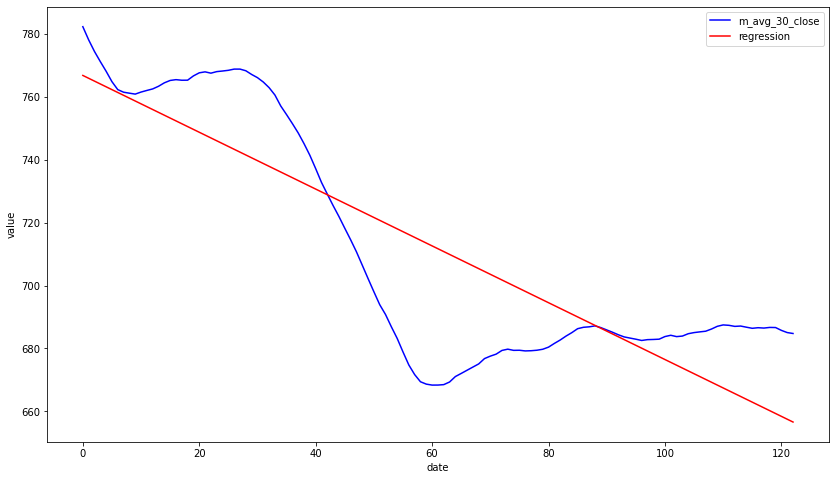

7202


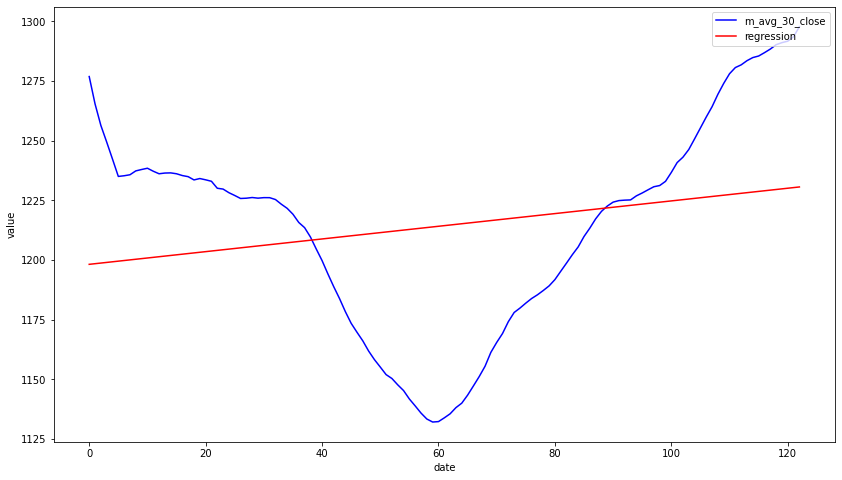

7239


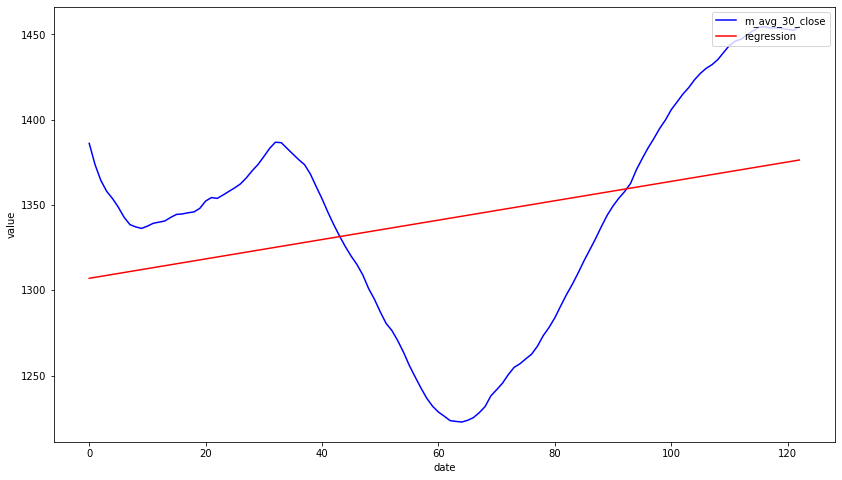

7261


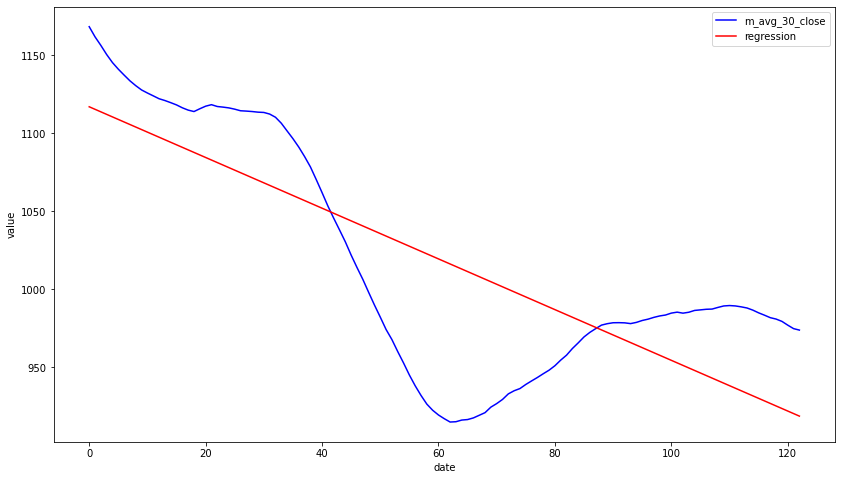

7267


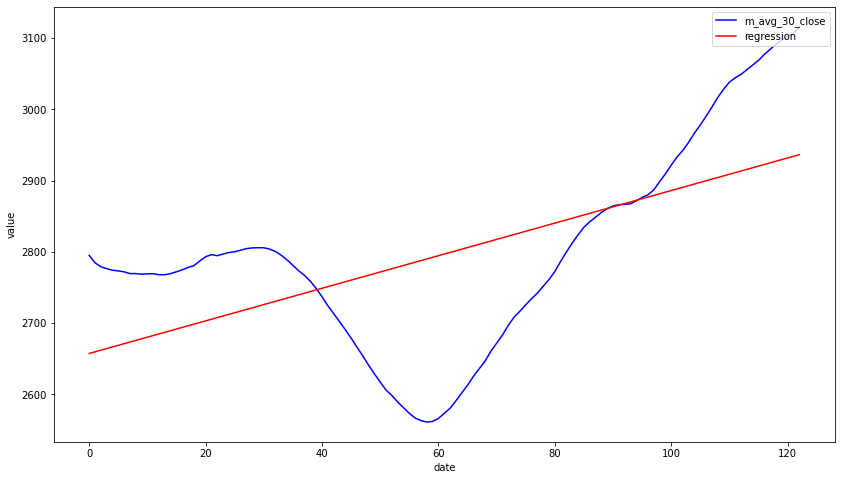

7417


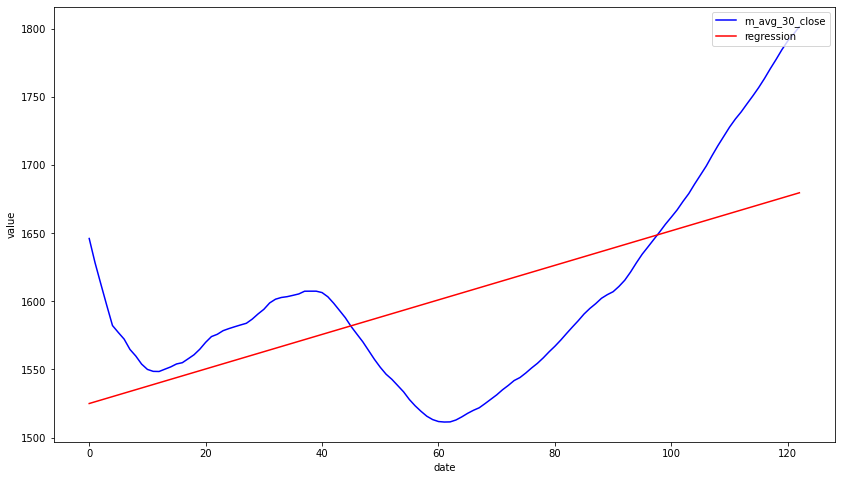

7455


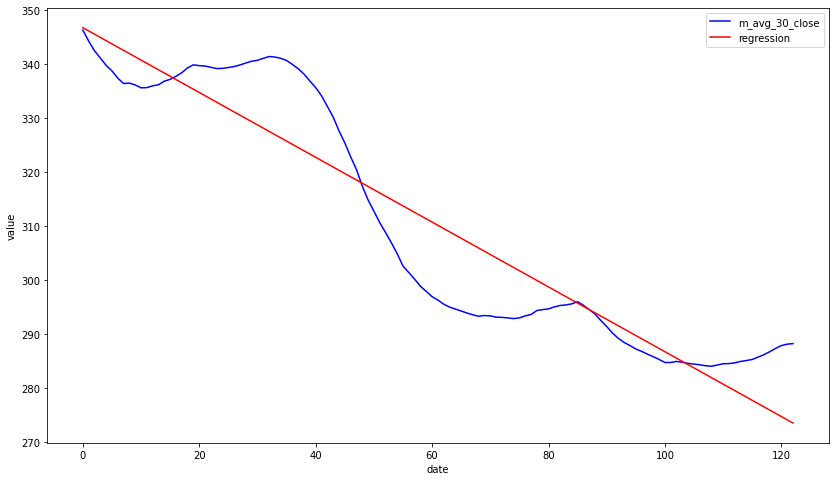

7487


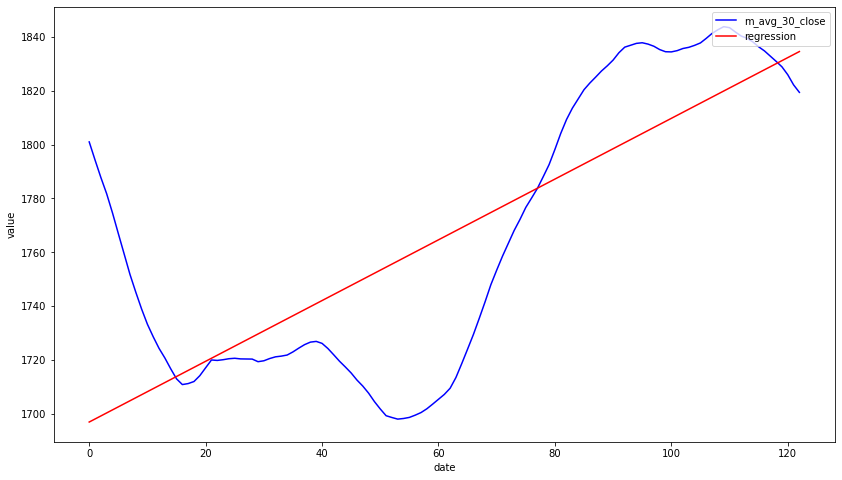

7537


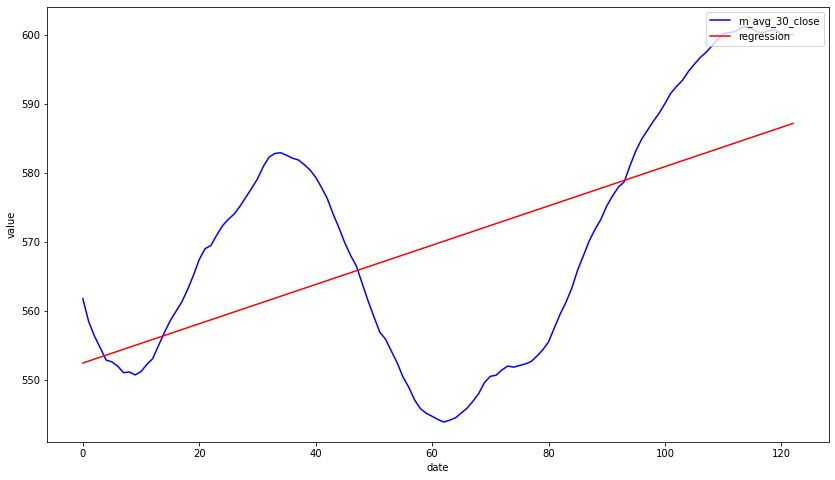

7717


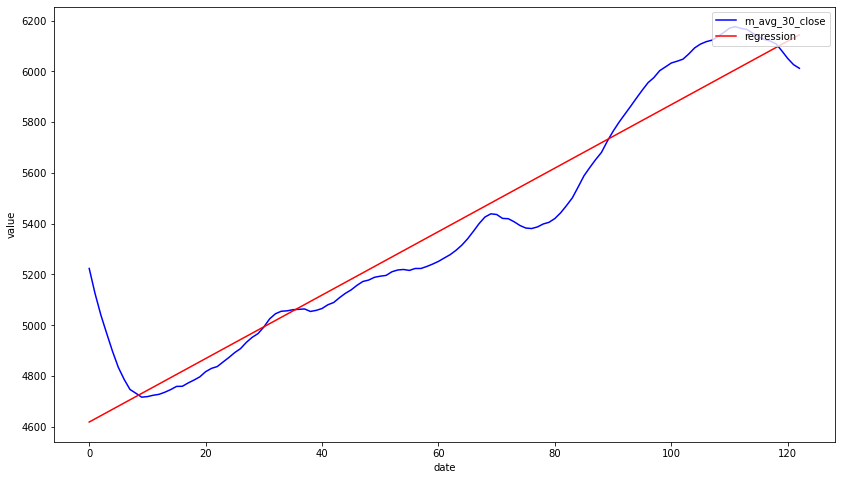

7722


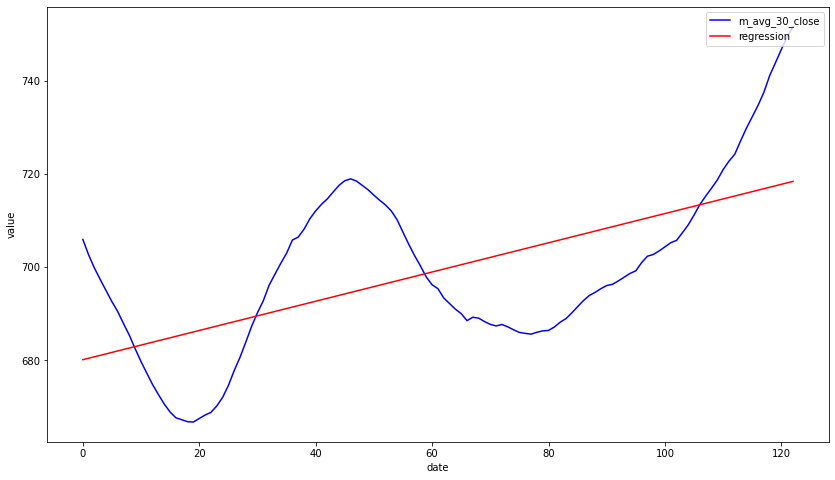

7822


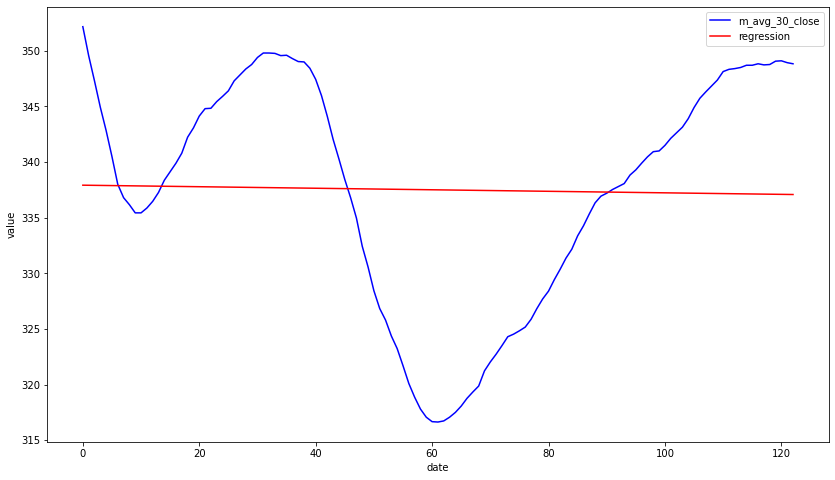

7864


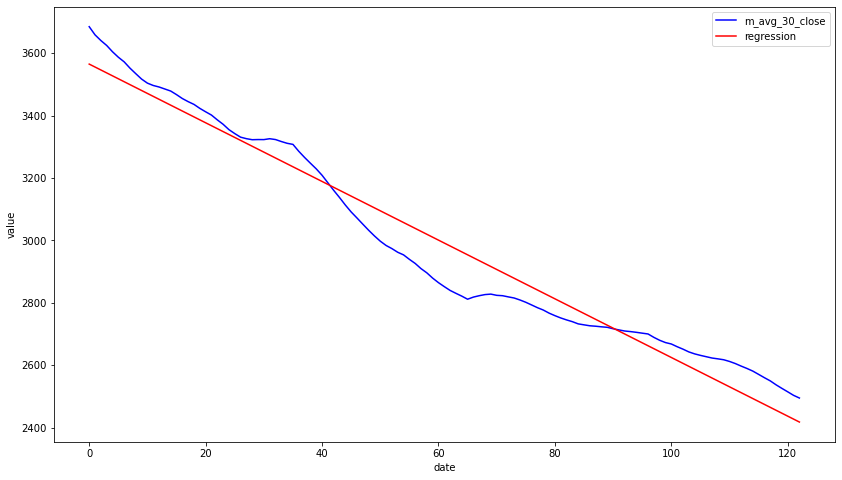

7865


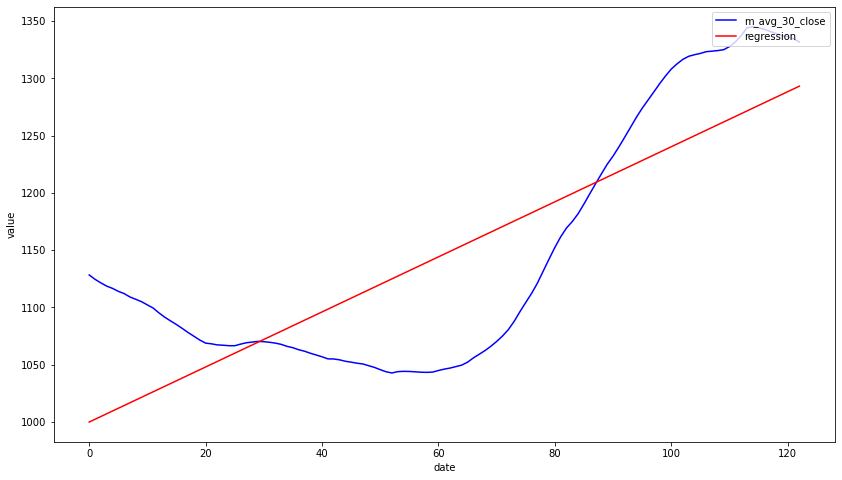

7918


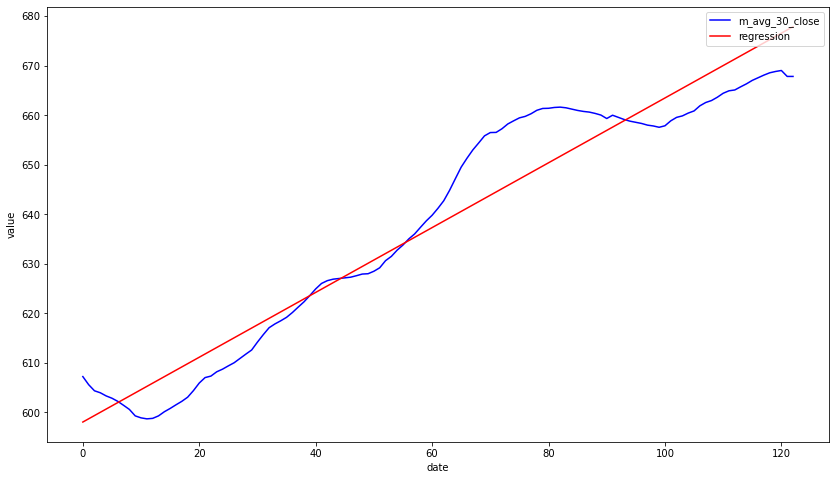

7936


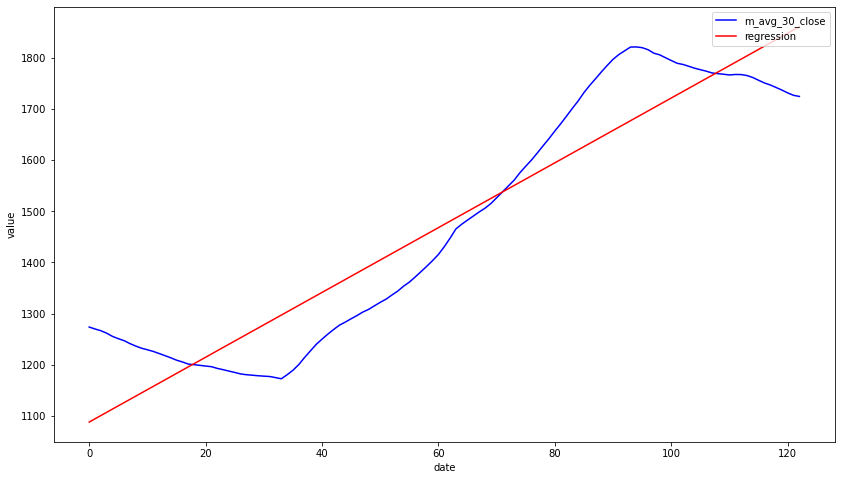

7972


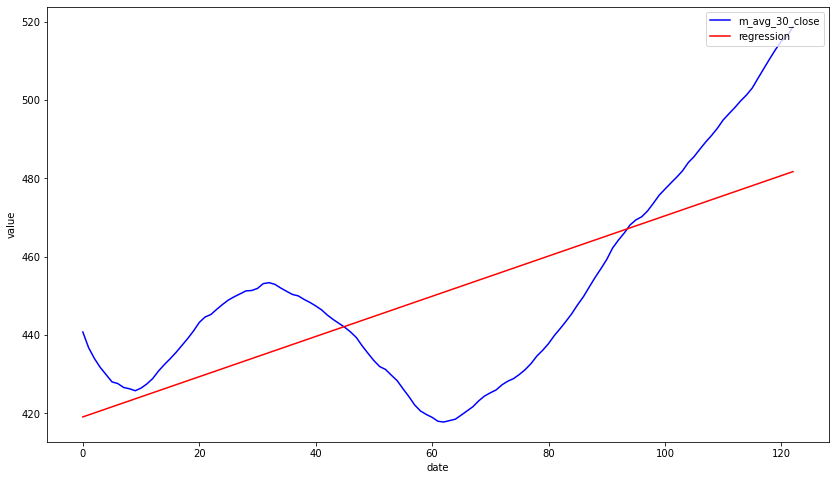

7976


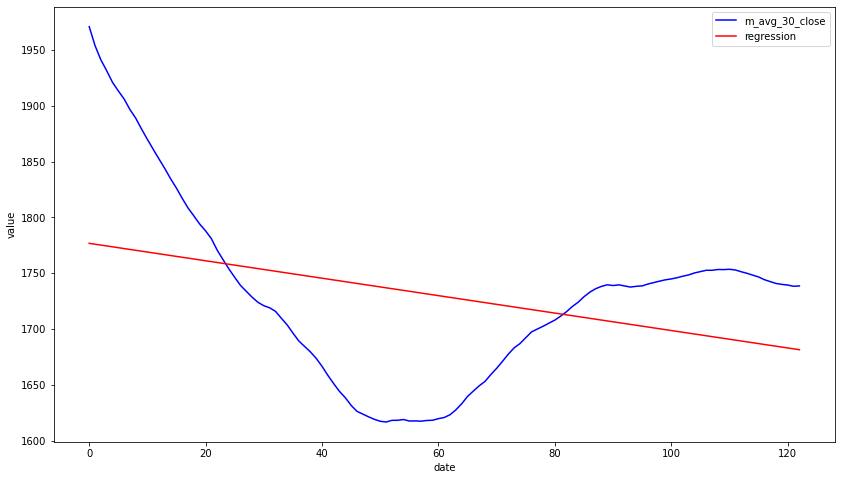

8013


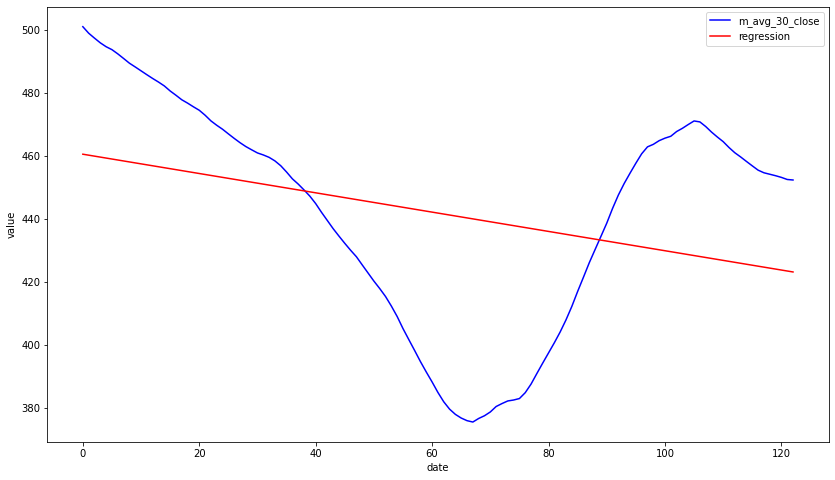

8032


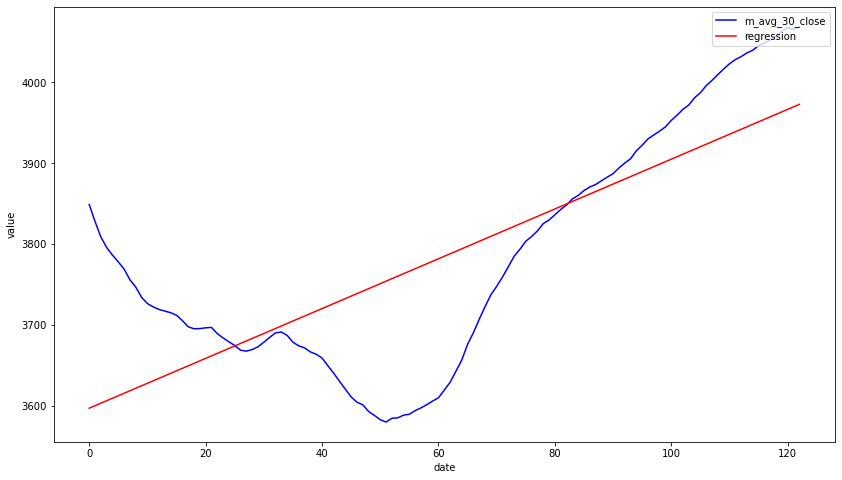

8059


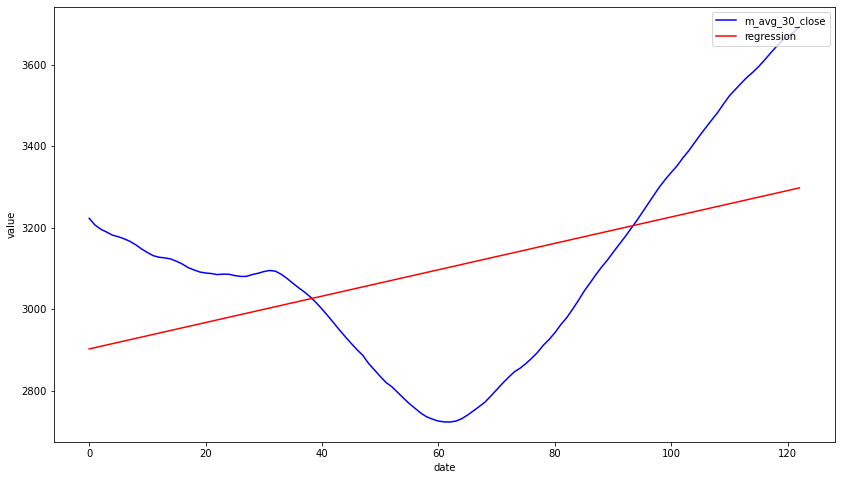

8086


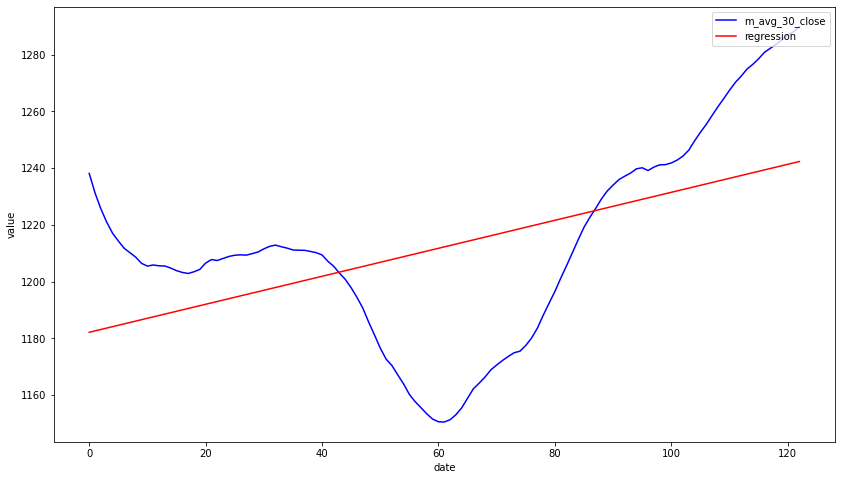

8089


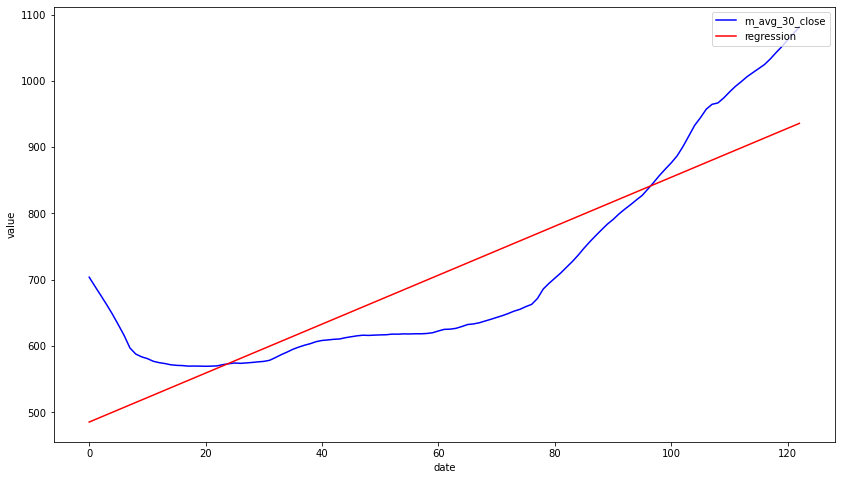

8132


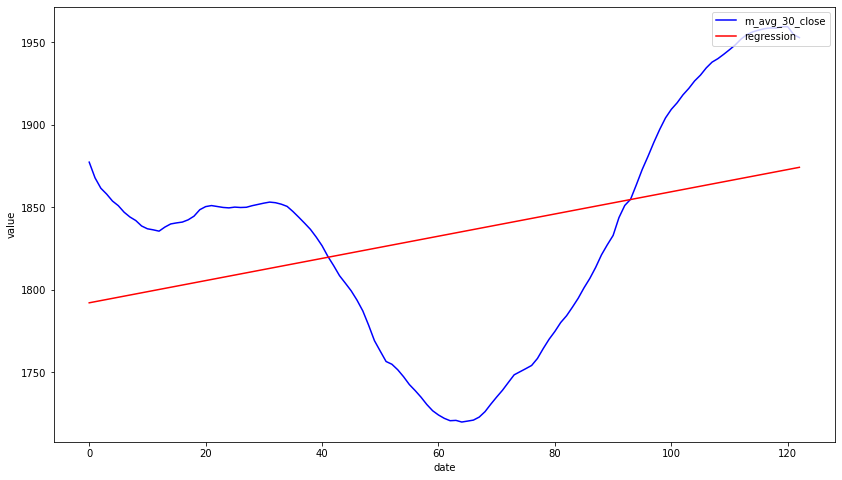

8153


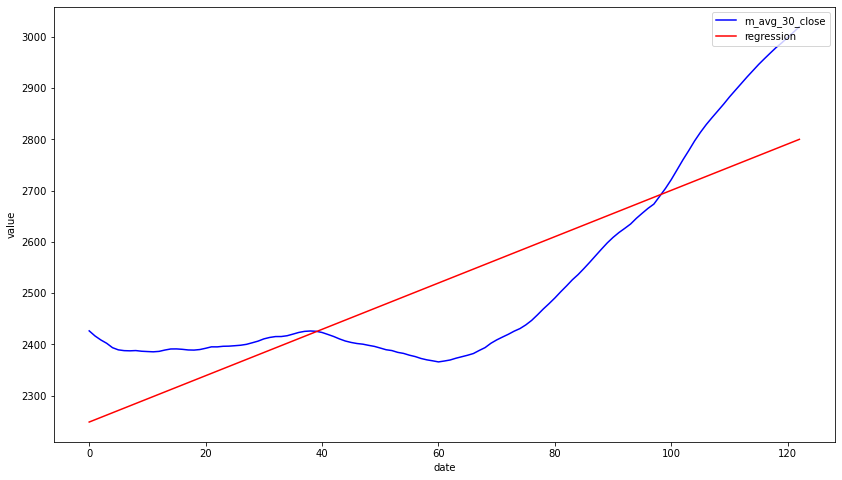

8154


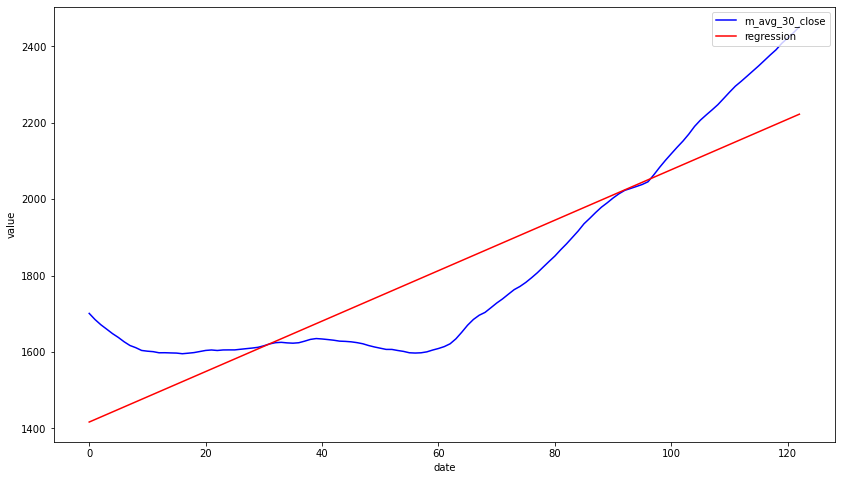

8198


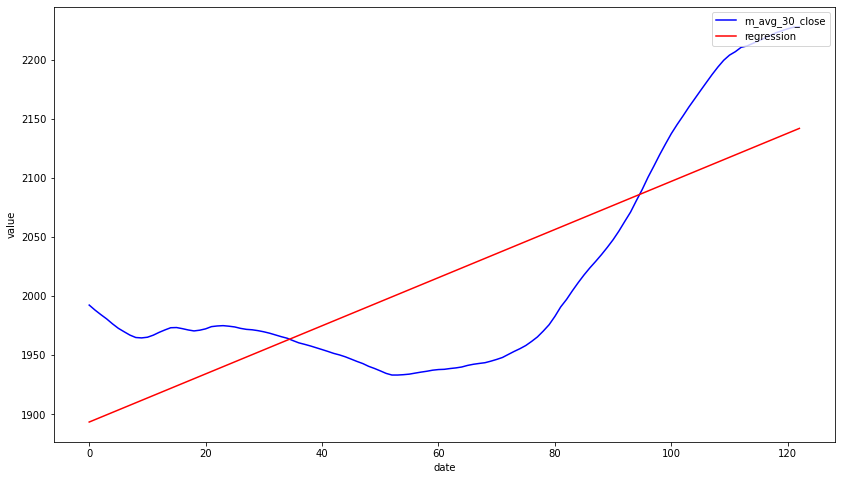

8242


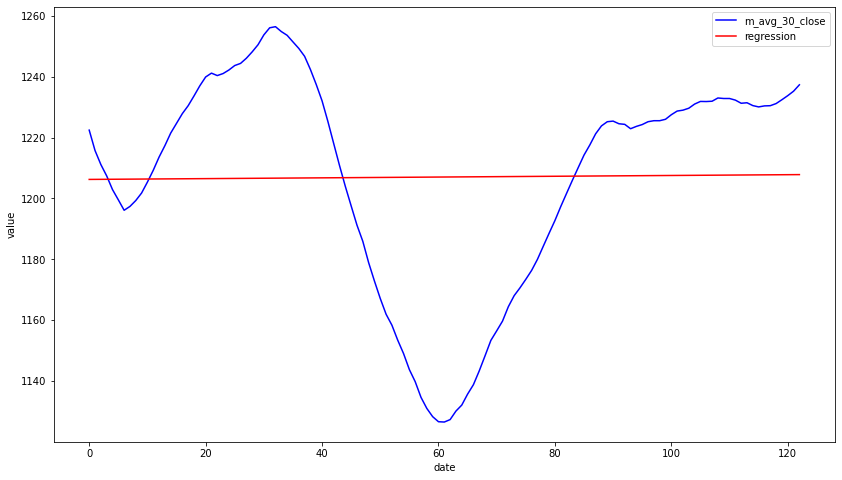

8267


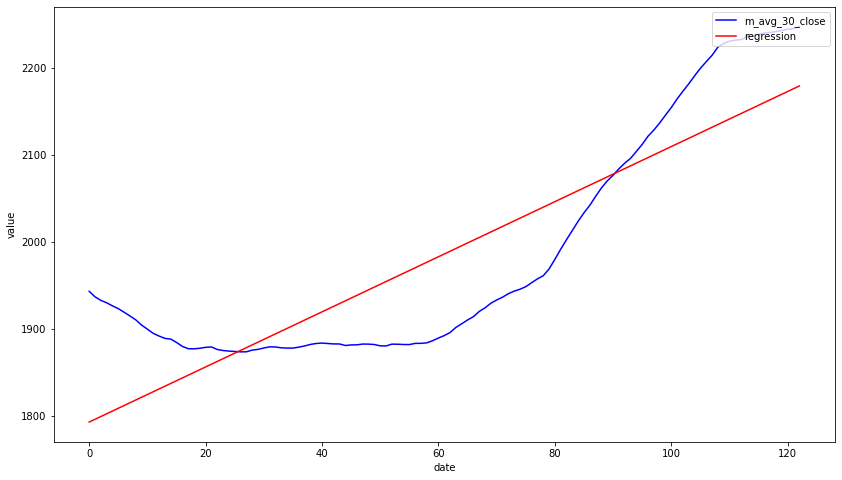

8279


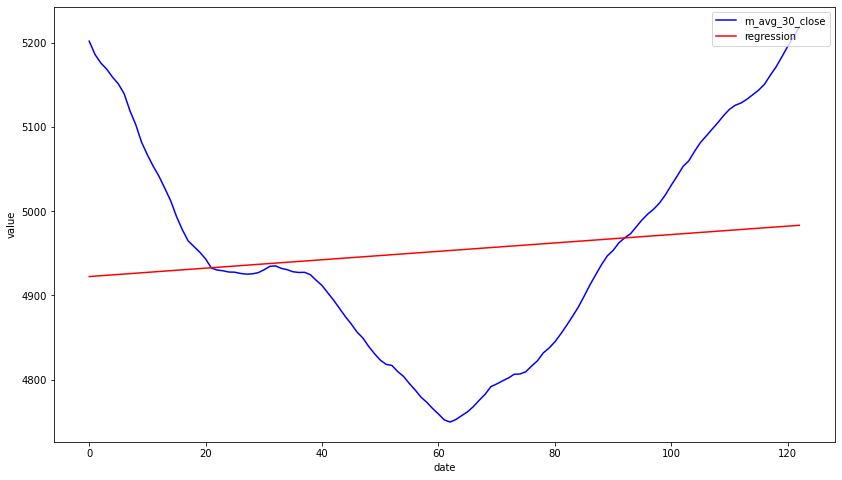

8354


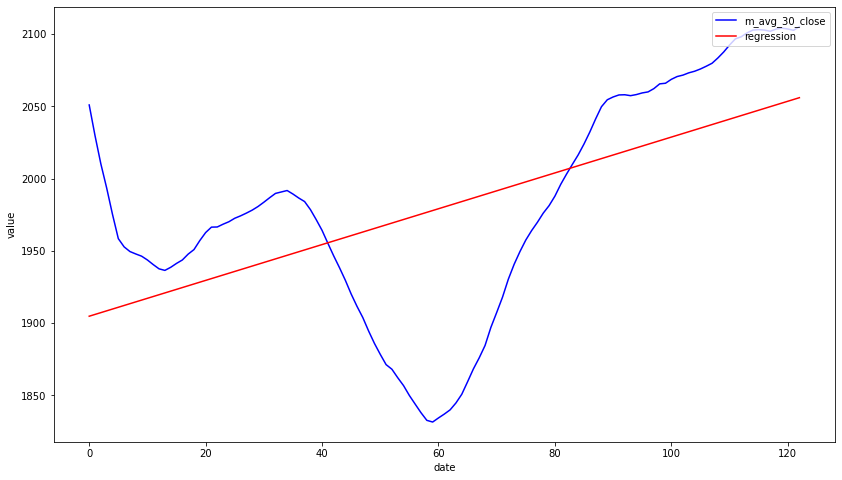

8411


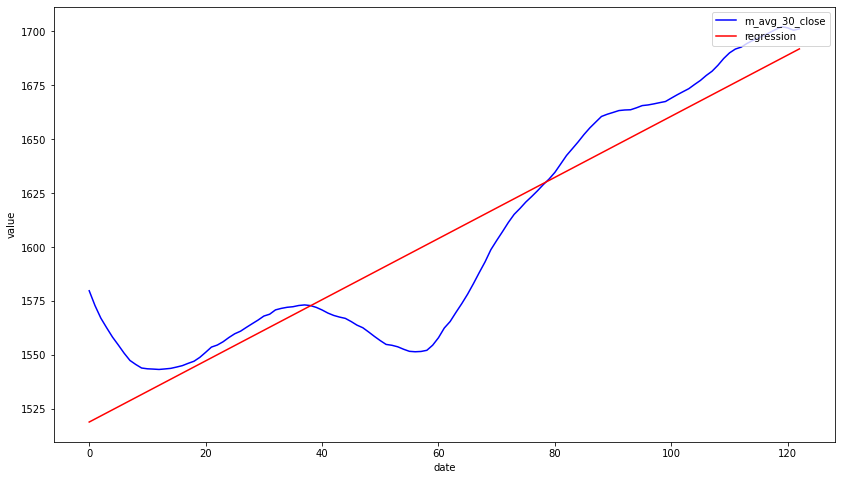

8418


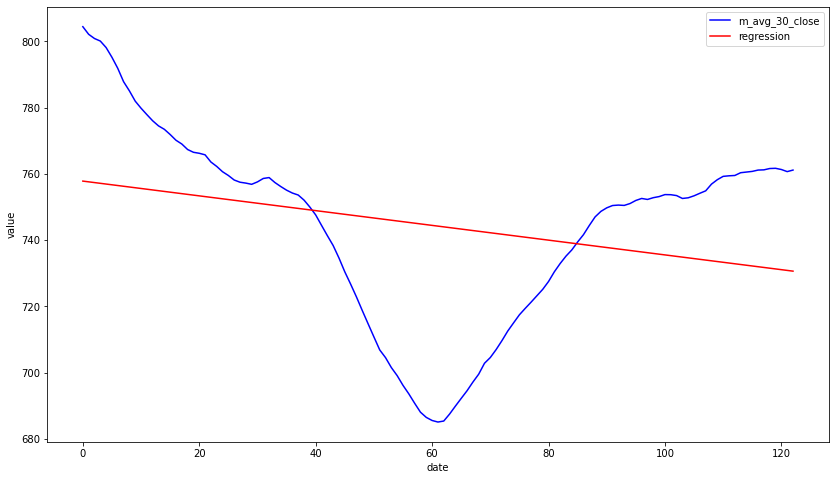

8570


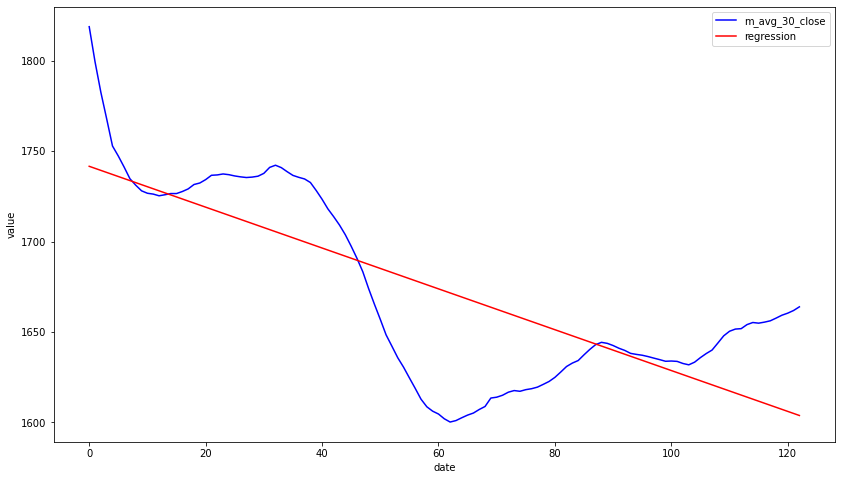

8596


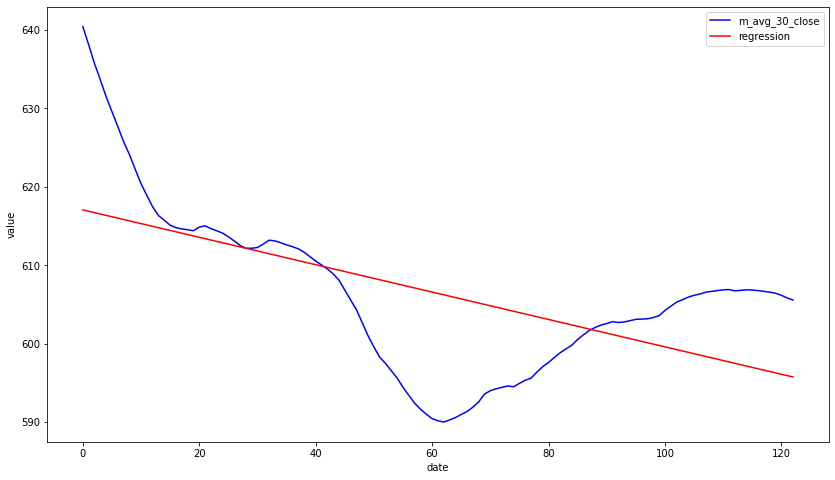

8699


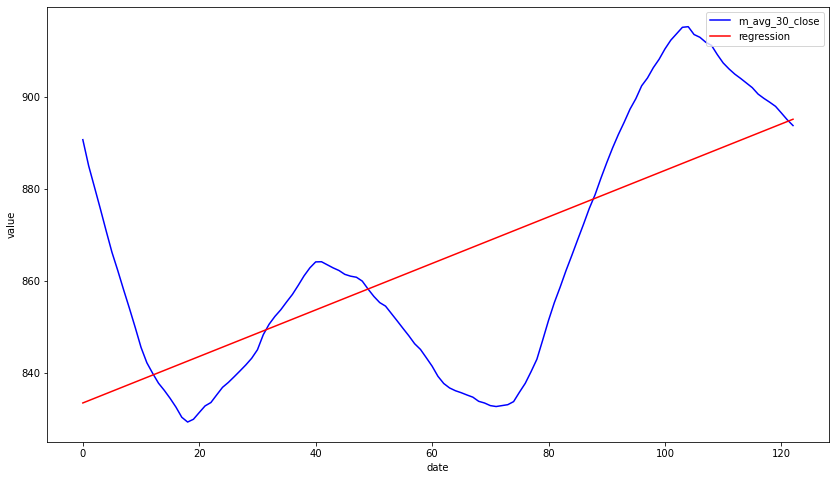

8714


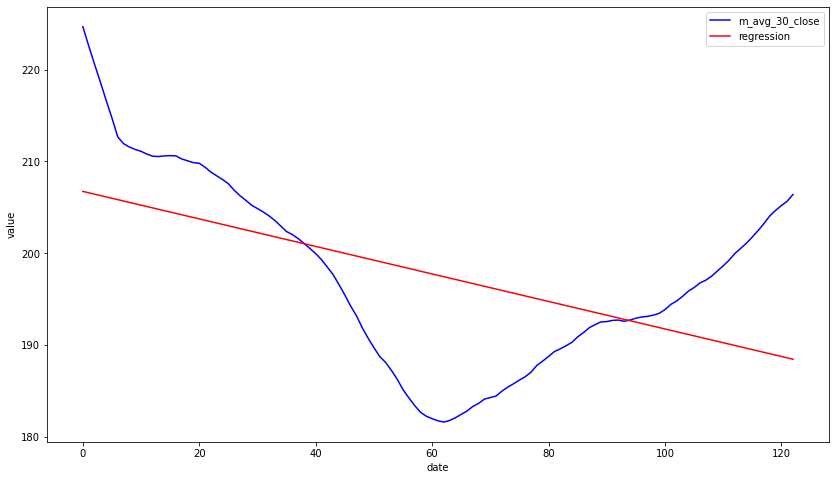

8769


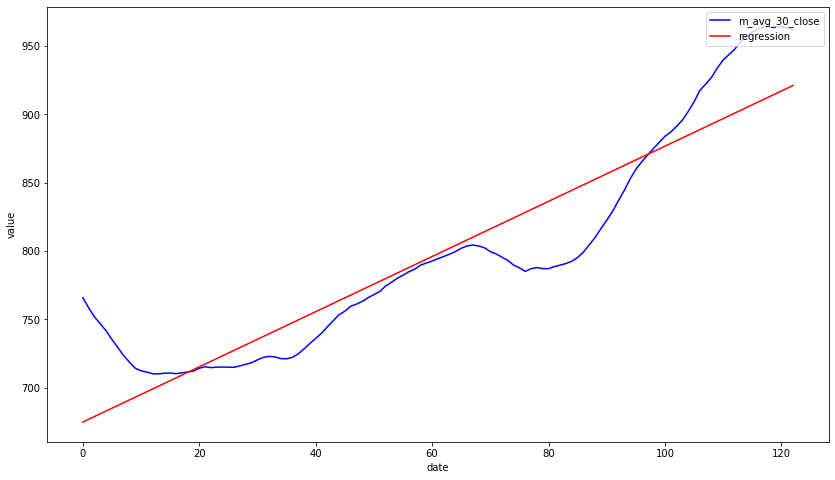

8841


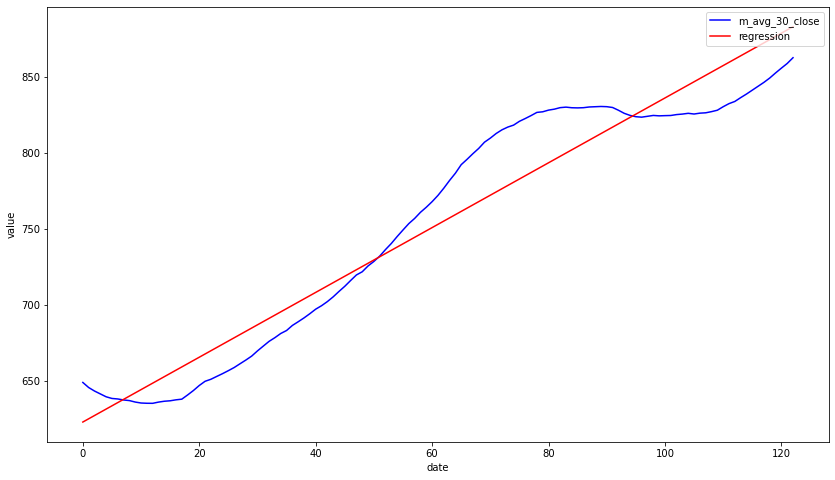

8860


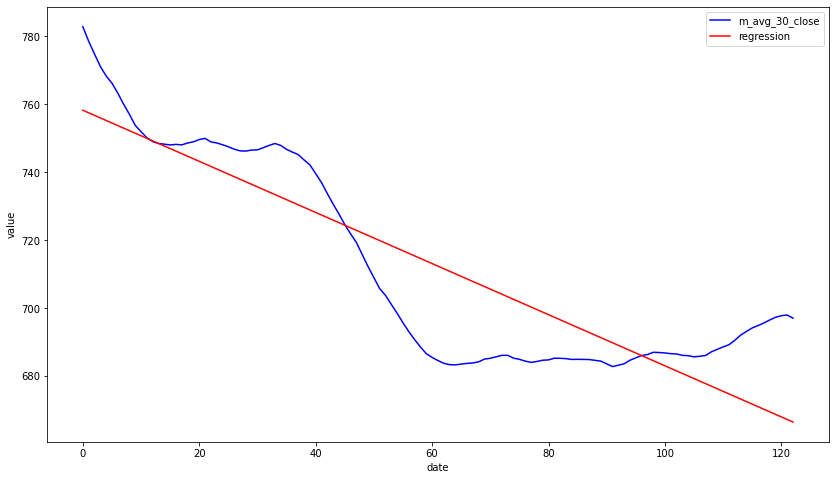

9031


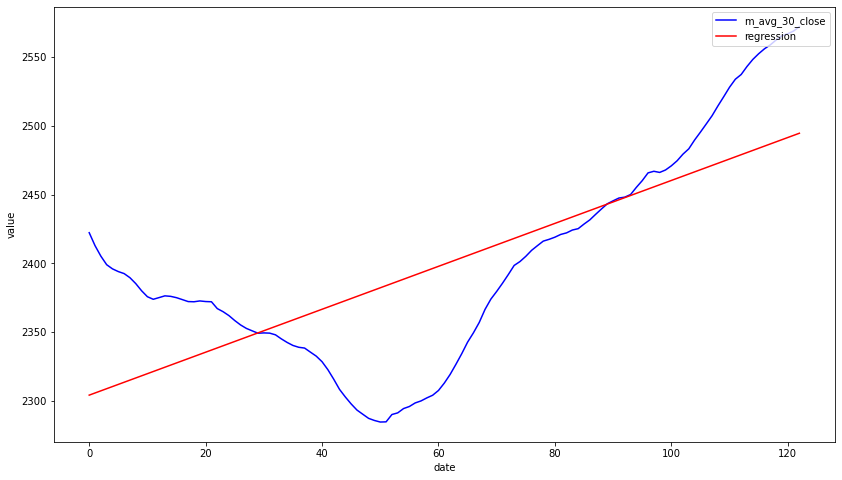

9064


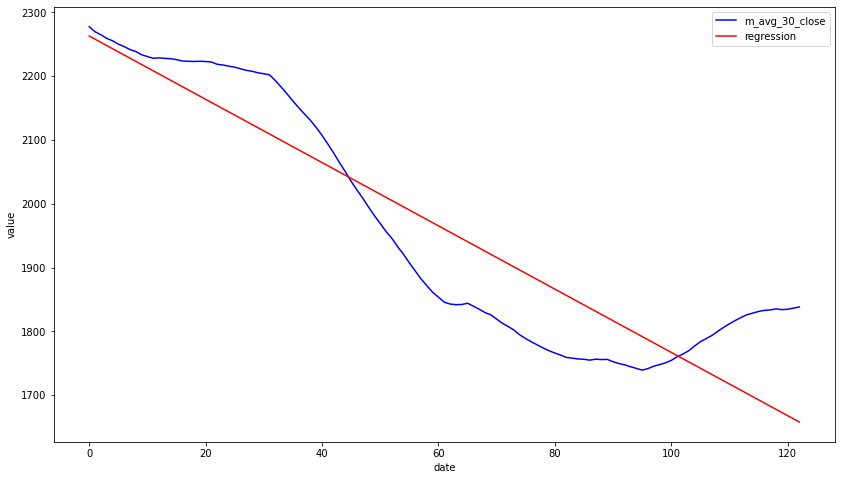

9201


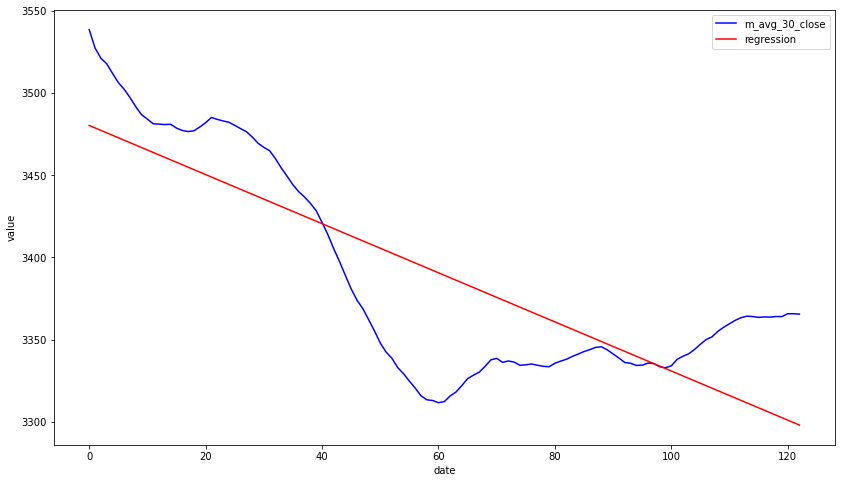

9270


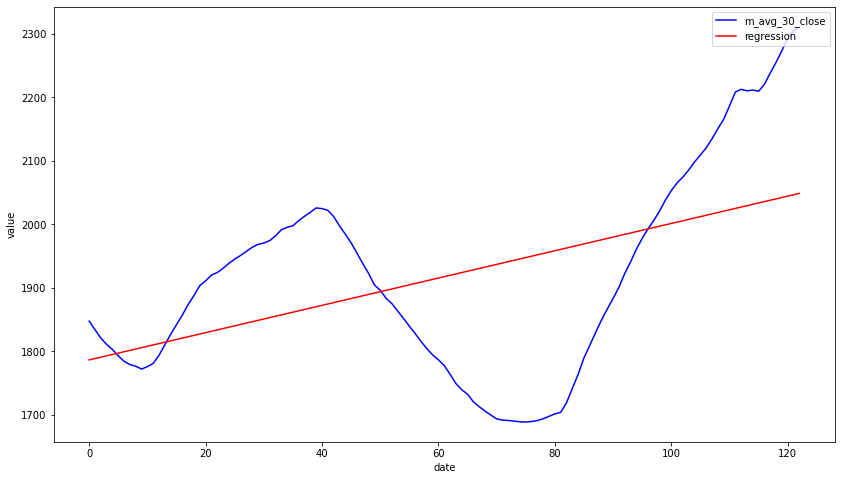

9503


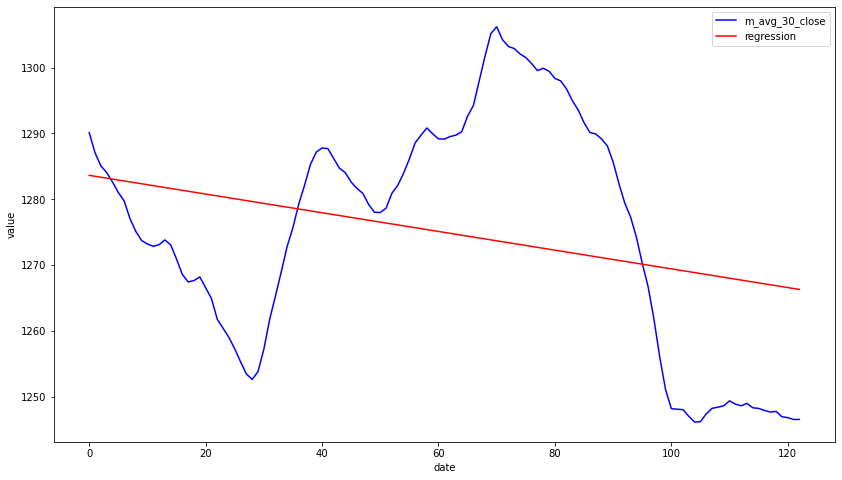

9506


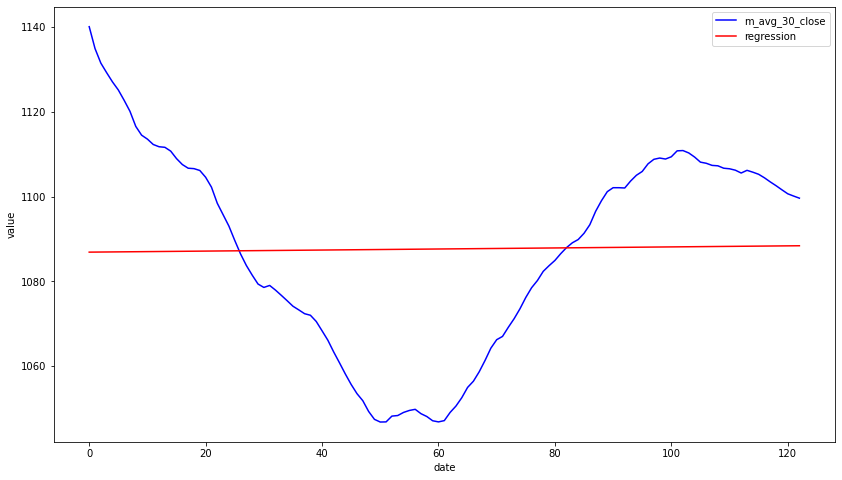

9507


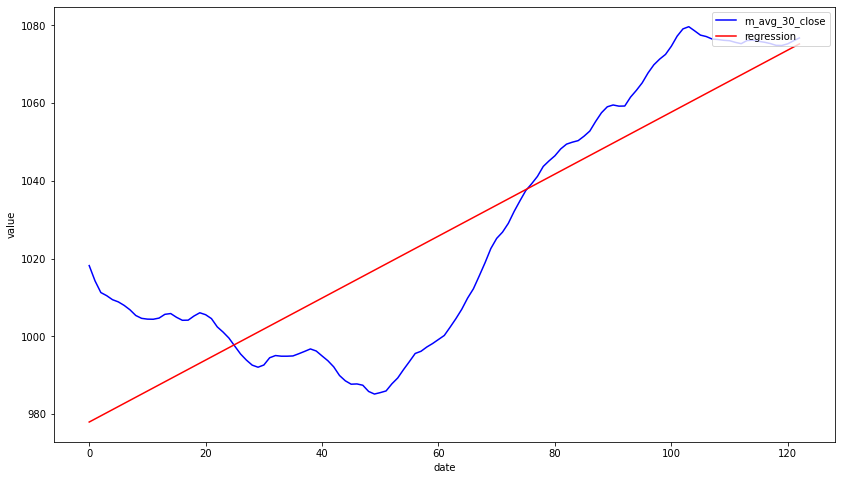

9532


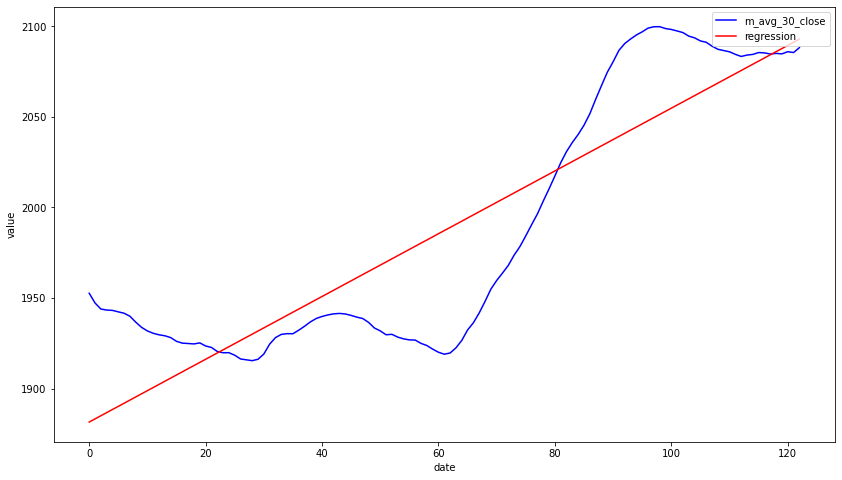

9603


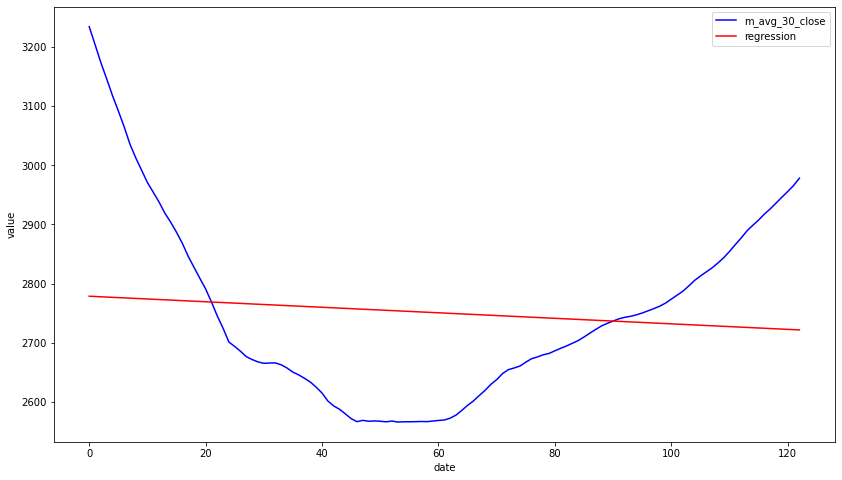

9627


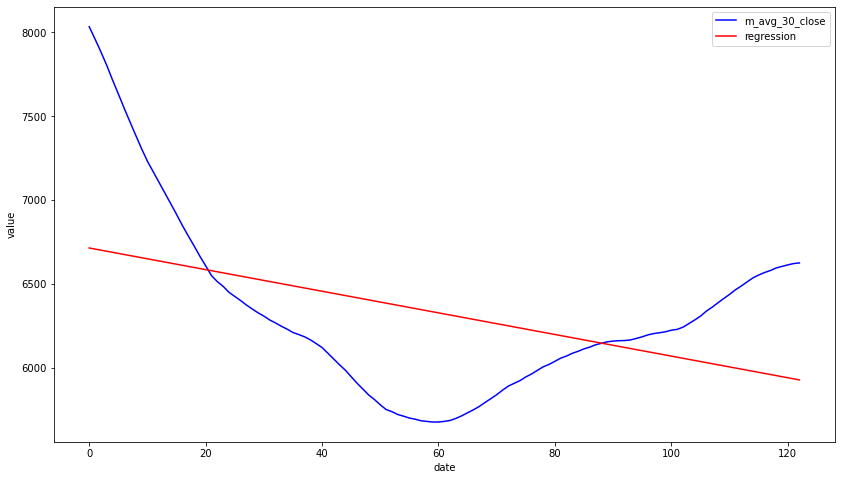

9787


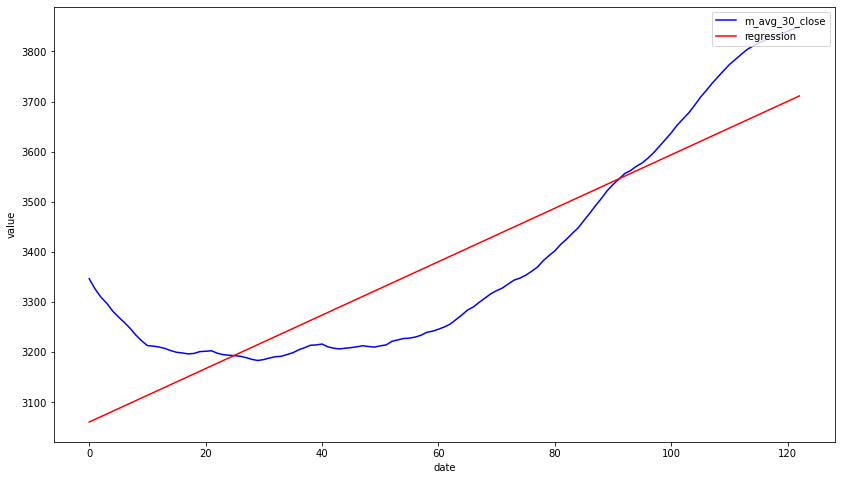

9830


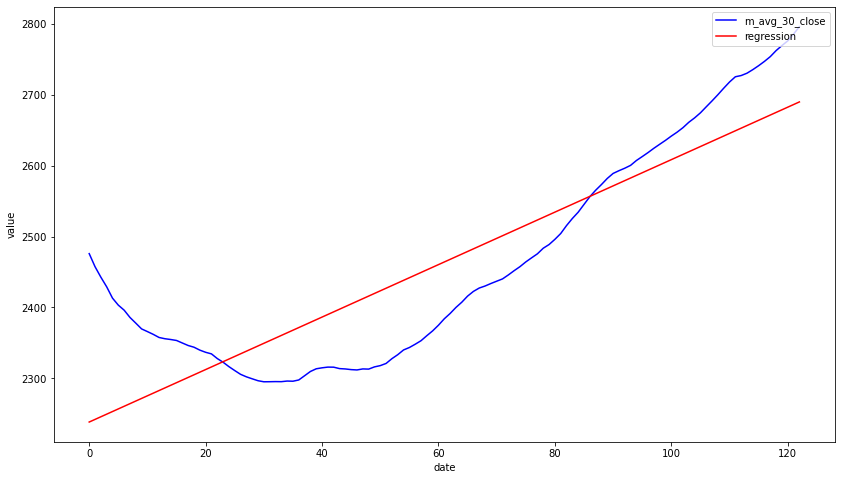

9887


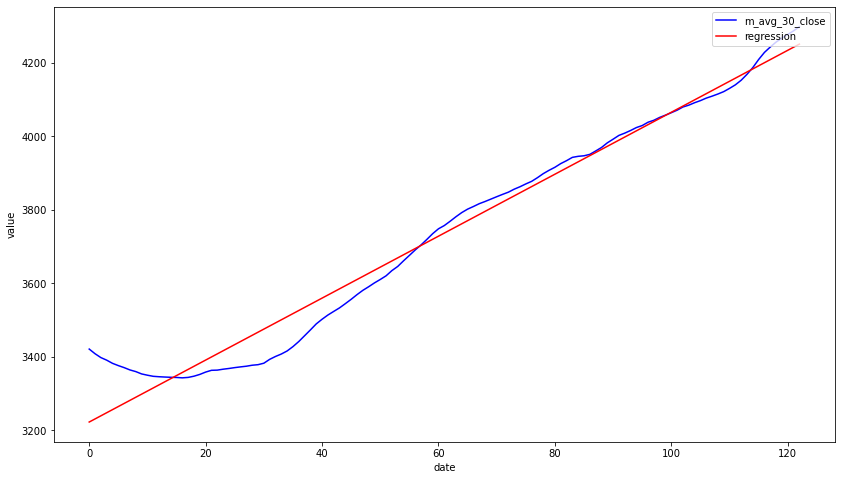

9904


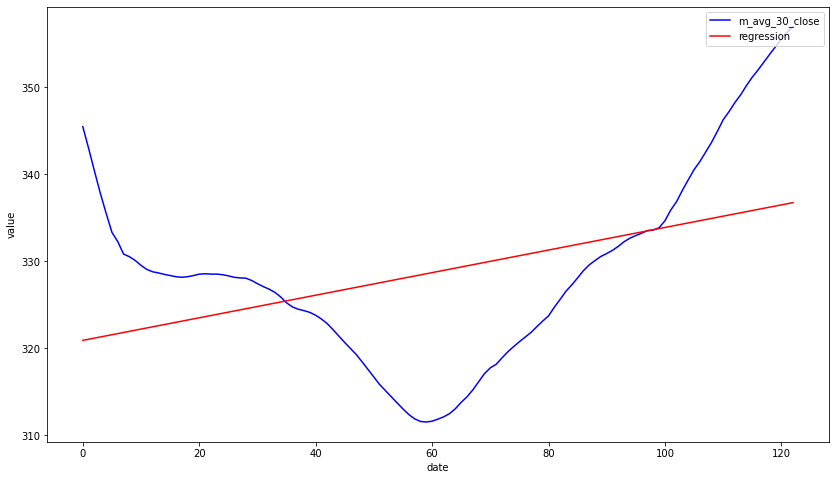

9946


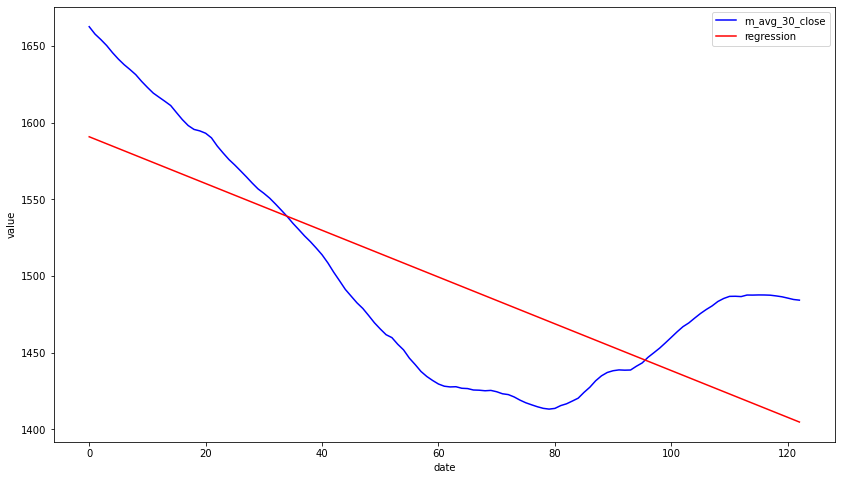

In [21]:
check_df = check(down_over_2std_codes, show_graph=True)

In [22]:
plus = len(check_df[check_df['grad'] > 0])
minus = len(check_df[check_df['grad'] < 0])

In [23]:
check_df.describe()

grad  max_profit    max_days  min_profit    min_days
count  143.000000  143.000000  143.000000  143.000000  143.000000
mean     0.909076    3.364203   73.594406   -0.976429   51.790210
std      5.328834    4.822337   55.967198    1.480289   26.847733
min    -10.174938    0.195588    0.000000   -8.933034    3.000000
25%     -0.355743    1.144403    0.000000   -1.543955   27.500000
50%      0.498728    2.191553  113.000000   -0.608911   60.000000
75%      1.887141    3.951676  122.000000   -0.012822   63.000000
max     52.142013   50.136657  122.000000    1.364265  122.000000

In [24]:
print('plus: {}'.format(plus / len(down_over_2std_codes)))
print('minus: {}'.format(minus / len(down_over_2std_codes)))

plus: 0.6433566433566433
minus: 0.35664335664335667


### 1.5σ ~ 2.0σ 下がった銘柄

In [25]:
check_df = check(down_between_1_5_and_2_0std_codes)

In [26]:
plus = len(check_df[check_df['grad'] > 0])
minus = len(check_df[check_df['grad'] < 0]) 

In [27]:
check_df.describe()

grad  max_profit    max_days  min_profit    min_days
count  382.000000  382.000000  382.000000  382.000000  382.000000
mean     1.047696    4.147545   83.578534   -1.572131   53.206806
std      4.350355    3.997782   51.198372    2.154543   29.639065
min     -9.856623   -0.281238    0.000000  -19.543498    0.000000
25%     -0.247730    1.336819   32.000000   -2.437494   35.000000
50%      0.400188    2.755363  119.000000   -1.017227   60.000000
75%      1.635411    5.990345  122.000000   -0.187491   64.000000
max     65.772401   28.398129  122.000000    1.532993  122.000000

In [28]:
print('plus: {}'.format(plus / len(down_between_1_5_and_2_0std_codes)))
print('minus: {}'.format(minus / len(down_between_1_5_and_2_0std_codes)))

plus: 0.662303664921466
minus: 0.337696335078534


### 1.0σ ~ 1.5σ 下がった銘柄

In [29]:
check_df = check(down_between_1_0_and_1_5std_codes)

In [30]:
plus = len(check_df[check_df['grad'] > 0])
minus = len(check_df[check_df['grad'] < 0]) 

In [31]:
check_df.describe()

grad  max_profit    max_days  min_profit    min_days
count  738.000000  738.000000  738.000000  738.000000  738.000000
mean     1.594546    5.515382   88.806233   -1.768649   47.168022
std      8.226125    7.556510   46.175279    2.205167   33.162017
min    -23.420262   -2.046768    0.000000  -13.843751    0.000000
25%     -0.065558    1.377412   38.000000   -2.576878    9.000000
50%      0.478343    3.546197  120.000000   -1.141986   59.000000
75%      1.683640    7.406011  122.000000   -0.226273   64.000000
max    196.097690  135.500790  122.000000    1.871544  122.000000

In [32]:
print('plus: {}'.format(plus / len(down_between_1_0_and_1_5std_codes)))
print('minus: {}'.format(minus / len(down_between_1_0_and_1_5std_codes)))

plus: 0.7181571815718157
minus: 0.28184281842818426


### 0.5σ ~ 1.0σ 下がった銘柄

In [33]:
check_df = check(down_between_0_5_and_1_0std_codes)

In [34]:
plus = len(check_df[check_df['grad'] > 0])
minus = len(check_df[check_df['grad'] < 0]) 

In [35]:
check_df.describe()

grad  max_profit    max_days  min_profit    min_days
count  621.000000  621.000000  621.000000  621.000000  621.000000
mean     1.577732    4.880678   87.932367   -2.106767   47.787440
std      5.405809    5.542992   45.271033    2.167781   34.521053
min    -11.472697   -1.938724    0.000000  -16.159777    0.000000
25%     -0.081654    1.145897   38.000000   -3.083521    8.000000
50%      0.488853    3.274271  119.000000   -1.670215   60.000000
75%      1.836428    6.889301  122.000000   -0.683672   64.000000
max     70.602797   47.156354  122.000000    1.274132  122.000000

In [36]:
print('plus: {}'.format(plus / len(down_between_0_5_and_1_0std_codes)))
print('minus: {}'.format(minus / len(down_between_0_5_and_1_0std_codes)))

plus: 0.7004830917874396
minus: 0.2995169082125604


### 0.0σ ~ 0.5σ 下がった銘柄

In [37]:
check_df = check(down_between_0_0_and_0_5std_codes)

In [38]:
plus = len(check_df[check_df['grad'] > 0])
minus = len(check_df[check_df['grad'] < 0]) 

In [39]:
check_df.describe()

grad  max_profit    max_days  min_profit    min_days
count  324.000000  324.000000  324.000000  324.000000  324.000000
mean     3.094935    4.190670   82.632716   -2.194151   45.916667
std     24.704023    5.071517   46.691309    2.335492   39.106299
min     -8.184769   -1.738347    0.000000  -12.624879    0.000000
25%     -0.231314    0.754746   33.000000   -2.807992    2.000000
50%      0.499804    2.612210  111.000000   -1.612745   59.000000
75%      2.290597    6.173566  122.000000   -0.785261   66.000000
max    420.217504   31.008323  122.000000    1.825020  122.000000

In [40]:
print('plus: {}'.format(plus / len(down_between_0_0_and_0_5std_codes)))
print('minus: {}'.format(minus / len(down_between_0_0_and_0_5std_codes)))

plus: 0.6635802469135802
minus: 0.33641975308641975


### 0.0σ ~ 0.5σ 上がった銘柄

In [41]:
check_df = check(up_between_0_0_and_0_5std_codes)

In [42]:
plus = len(check_df[check_df['grad'] > 0])
minus = len(check_df[check_df['grad'] < 0]) 

In [43]:
check_df.describe()

grad  max_profit    max_days  min_profit    min_days
count   246.000000  246.000000  246.000000  246.000000  246.000000
mean      9.478119    4.314515   83.638211   -2.223459   47.321138
std      75.762677    5.366599   46.779151    2.104291   39.649157
min     -28.515779   -2.148774    0.000000  -11.331730    0.000000
25%      -0.375617    0.746990   33.000000   -3.115216    2.000000
50%       0.432947    2.692591  113.500000   -1.684103   58.500000
75%       2.238658    5.313222  122.000000   -0.755729   68.000000
max    1038.568551   32.147348  122.000000    0.910779  122.000000

In [44]:
print('plus: {}'.format(plus / len(up_between_0_0_and_0_5std_codes)))
print('minus: {}'.format(minus / len(up_between_0_0_and_0_5std_codes)))

plus: 0.6422764227642277
minus: 0.35772357723577236


### 0.5σ ~ 1.0σ 上がった銘柄

In [45]:
check_df = check(up_between_0_5_and_1_0std_codes)

In [46]:
plus = len(check_df[check_df['grad'] > 0])
minus = len(check_df[check_df['grad'] < 0]) 

In [47]:
check_df.describe()

grad  max_profit    max_days  min_profit    min_days
count  183.000000  183.000000  183.000000  183.000000  183.000000
mean     3.201707    4.743248   78.606557   -2.463824   52.322404
std     26.534545   15.675956   47.703392    2.799473   40.777066
min    -30.733298   -2.682414    0.000000  -18.819855    0.000000
25%     -1.045481    0.678127   30.000000   -3.329824    5.000000
50%      0.253418    2.202525  106.000000   -1.721027   61.000000
75%      2.107601    5.355876  122.000000   -0.865197   77.000000
max    327.776158  206.042407  122.000000    1.384897  122.000000

In [48]:
print('plus: {}'.format(plus / len(up_between_0_5_and_1_0std_codes)))
print('minus: {}'.format(minus / len(up_between_0_5_and_1_0std_codes)))

plus: 0.5846994535519126
minus: 0.41530054644808745


### 1.0σ ~ 1.5σ 上がった銘柄

In [49]:
check_df = check(up_between_1_0_and_1_5std_codes)

In [50]:
plus = len(check_df[check_df['grad'] > 0])
minus = len(check_df[check_df['grad'] < 0]) 

In [51]:
check_df.describe()

grad  max_profit    max_days  min_profit    min_days
count  121.000000  121.000000  121.000000  121.000000  121.000000
mean    38.648930    4.952478   70.727273   -2.334520   48.074380
std    133.146344    5.866732   47.475432    2.292606   41.965892
min    -35.249139   -0.869247    0.000000   -9.823893    0.000000
25%     -1.132002    0.942528   27.000000   -3.688938    0.000000
50%      0.543423    2.354792   94.000000   -1.736031   56.000000
75%      3.187204    8.160853  120.000000   -0.692748   77.000000
max    865.250889   22.429253  122.000000    0.965519  122.000000

In [52]:
print('plus: {}'.format(plus / len(up_between_1_0_and_1_5std_codes)))
print('minus: {}'.format(minus / len(up_between_1_0_and_1_5std_codes)))

plus: 0.5867768595041323
minus: 0.4132231404958678


### 1.5σ ~ 2.0σ 上がった銘柄

In [53]:
check_df = check(up_between_1_5_and_2_0std_codes)

In [54]:
plus = len(check_df[check_df['grad'] > 0])
minus = len(check_df[check_df['grad'] < 0]) 

In [55]:
check_df.describe()

grad  max_profit    max_days  min_profit    min_days
count   100.000000  100.000000  100.000000  100.000000  100.000000
mean     76.108157    5.031377   82.210000   -2.219973   40.320000
std     204.467321    5.614878   44.211908    2.100974   39.082632
min     -25.127958   -1.784751    0.000000   -9.874129    0.000000
25%      -0.483884    0.846305   35.250000   -2.698303    0.000000
50%       1.214152    3.745817   98.000000   -1.657115   42.500000
75%       6.080161    7.532047  122.000000   -0.807246   67.000000
max    1005.640862   25.939951  122.000000    0.324751  122.000000

In [56]:
print('plus: {}'.format(plus / len(up_between_1_5_and_2_0std_codes)))
print('minus: {}'.format(minus / len(up_between_1_5_and_2_0std_codes)))

plus: 0.65
minus: 0.35


### 2.0σ 以上上がった銘柄

In [57]:
check_df = check(up_over_2std_codes)

In [58]:
plus = len(check_df[check_df['grad'] > 0])
minus = len(check_df[check_df['grad'] < 0]) 

In [59]:
check_df.describe()

grad  max_profit    max_days  min_profit    min_days
count  126.000000  126.000000  126.000000  126.000000  126.000000
mean    23.668288    3.425312   75.380952   -2.306204   36.968254
std     72.956256    5.005785   42.782587    1.364755   41.906932
min    -24.597881   -1.746559    3.000000   -8.181589    0.000000
25%     -1.308100   -0.020051   28.000000   -3.071262    0.000000
50%      0.941633    1.624209   95.000000   -1.852546    0.500000
75%      4.657228    4.936844  122.000000   -1.375887   66.750000
max    389.697562   29.059731  122.000000   -0.174135  122.000000

In [60]:
print('plus: {}'.format(plus / len(up_over_2std_codes)))
print('minus: {}'.format(minus / len(up_over_2std_codes)))

plus: 0.6190476190476191
minus: 0.38095238095238093


# 結論
全体的に平均より値下がりしている銘柄の方が値上がりしそうな数値となったが、  
根拠としては弱い数値

特定の日に限らずいくつかの日で調査が必要